# Reproducible Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import pandas as pd

from requests import get
from urllib.parse import urlparse
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler


import matplotlib.cm as cm
import matplotlib.pyplot as plt

from shapely import geometry
import json
import gzip

import random
random.seed(31)
np.random.seed(31)

from IPython.display import Image



In [2]:
sns.set_style('dark')

In [3]:
def cache_data(src:str, dest:str) -> str:
    
    url = urlparse(src)
    fn  = os.path.split(url.path)[-1] 
    dfn = os.path.join(dest,fn)
    
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [4]:
def plt_ldn(w, b):
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

## Accident data

In [5]:
ddir  = os.path.join('data','raw') 
cols = ['id','lat','lon','date','borough','severity','casualties_num']
df = pd.read_csv( cache_data('https://raw.githubusercontent.com/hongsliu/sdc/main/bike_accidents.csv', ddir),
                 usecols=cols, low_memory=False)
df.info()

data/raw/bike_accidents.csv not found, downloading!
	Done downloading...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9616 entries, 0 to 9615
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9616 non-null   int64  
 1   lat             9616 non-null   float64
 2   lon             9616 non-null   float64
 3   date            9616 non-null   object 
 4   borough         9616 non-null   object 
 5   severity        9616 non-null   object 
 6   casualties_num  9616 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 526.0+ KB


In [6]:
#df['price'] = df.price.astype(str).str.replace('$','').str.replace(',','').astype(float)
df.drop(df[((df.lat.isna())|(df.lon.isna()))].index, axis=0, inplace=True)
df.drop(df[((df.lat < 40)|(df.lon > 1))].index, axis=0, inplace=True)
print(df.shape)

(9616, 7)


In [7]:
df.describe()

id          lat          lon  casualties_num
count    9616.000000  9616.000000  9616.000000     9616.000000
mean   544135.507488    51.501718    -0.126150        1.031822
std    185714.394824     0.054318     0.110451        0.194640
min    345830.000000    51.295233    -0.493331        1.000000
25%    358502.000000    51.470096    -0.182363        1.000000
50%    544055.000000    51.507092    -0.116564        1.000000
75%    729640.000000    51.534558    -0.067249        1.000000
max    742280.000000    51.681720     0.276899        6.000000

In [8]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat, crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

In [9]:
ddir_geo  = os.path.join('data','geo') 
msoas = gpd.read_file( cache_data('https://github.com/hongsliu/sdc/raw/main/London_MSOAs.gpkg', ddir_geo),low_memory=False)
msoadf  = gpd.sjoin(gdf.reset_index(), 
            msoas, op='within')

data/geo/London_MSOAs.gpkg not found, downloading!
	Done downloading...


In [10]:
msoadf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9588 entries, 0 to 9588
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   index           9588 non-null   int64   
 1   id              9588 non-null   int64   
 2   lat             9588 non-null   float64 
 3   lon             9588 non-null   float64 
 4   date            9588 non-null   object  
 5   borough         9588 non-null   object  
 6   severity        9588 non-null   object  
 7   casualties_num  9588 non-null   int64   
 8   geometry        9588 non-null   geometry
 9   index_right     9588 non-null   int64   
 10  OBJECTID        9588 non-null   int64   
 11  MSOA11CD        9588 non-null   object  
 12  MSOA11NM        9588 non-null   object  
 13  BNG_E           9588 non-null   int64   
 14  BNG_N           9588 non-null   int64   
 15  Borough         9588 non-null   object  
 16  msoa11hclnm     9588 non-null   object  
dtypes: flo

In [11]:
msoadf.head()

index      id        lat       lon                       date  \
0         0  345988  51.461446 -0.298206  2019-01-05 11:35:00+00:00   
23       23  350784  51.461680 -0.287703  2019-03-19 19:05:00+00:00   
1043   1043  717128  51.461446 -0.298206  2019-01-05 11:35:00+00:00   
2630   2630  349454  51.462233 -0.293613  2019-03-01 18:15:00+00:00   
2756   2756  363308  51.461516 -0.298088  2019-09-20 17:35:00+00:00   

                   borough severity  casualties_num  \
0     Richmond upon Thames   Slight               1   
23    Richmond upon Thames   Slight               1   
1043  Richmond upon Thames   Slight               1   
2630  Richmond upon Thames  Serious               1   
2756  Richmond upon Thames   Slight               1   

                           geometry  index_right  OBJECTID   MSOA11CD  \
0     POINT (518322.038 174981.040)          759       760  E02000789   
23    POINT (519051.036 175024.067)          759       760  E02000789   
1043  POINT (518322.038 174981.040)          759       760  E02000789   
2630  POINT (518639.059 175075.982)          759       760  E02000789   
2756  POINT (518330.055 174989.015)          759       760  E02000789   

                      MSOA11NM   BNG_E   BNG_N               Borough  \
0     Richmond upon Thames 006  518896  174322  Richmond upon Thames   
23    Richmond upon Thames 006  518896  174322  Richmond upon Thames   
1043  Richmond upon Thames 006  518896  174322  Richmond upon Thames   
2630  Richmond upon Thames 006  518896  174322  Richmond upon Thames   
2756  Richmond upon Thames 006  518896  174322  Richmond upon Thames   

       msoa11hclnm  
0     Queen's Road  
23    Queen's Road  
1043  Queen's Road  
2630  Queen's Road  
2756  Queen's Road

In [12]:
borogrdf = msoadf.groupby('Borough').agg({'casualties_num':['sum']}).reset_index()
borogrdf.head()

Borough casualties_num
                                   sum
0  Barking and Dagenham            126
1                Barnet            132
2                Bexley             64
3                 Brent            156
4               Bromley            208

In [13]:
borogrdf.columns = borogrdf.columns.get_level_values(0)
borogrdf.head()

Borough  casualties_num
0  Barking and Dagenham             126
1                Barnet             132
2                Bexley              64
3                 Brent             156
4               Bromley             208

In [14]:
borogrdf.sort_values(by='casualties_num', ascending=False).head(10)

Borough  casualties_num
32             Westminster             892
27               Southwark             786
21                 Lambeth             672
29           Tower Hamlets             632
31              Wandsworth             552
5                   Camden             538
18               Islington             532
11                 Hackney             468
12  Hammersmith and Fulham             352
19  Kensington and Chelsea             340

In [15]:
borogrdf.describe()

casualties_num
count       33.000000
mean       299.757576
std        217.134611
min         64.000000
25%        132.000000
50%        252.000000
75%        352.000000
max        892.000000

In [16]:
msoagrdf = msoadf.groupby('MSOA11NM')['casualties_num'].agg(['sum','count']).reset_index()
#df.groupby(['A', 'B'])['C'].agg([func1, func2])
msoagrdf.head()

MSOA11NM  sum  count
0  Barking and Dagenham 001    2      2
1  Barking and Dagenham 002   16     16
2  Barking and Dagenham 004    4      4
3  Barking and Dagenham 006    4      4
4  Barking and Dagenham 007    8      8

In [17]:
#msoagrdf = msoadf.groupby('MSOA11NM').agg({'casualties_num':['sum']}).reset_index()
#msoagrdf.head()

In [18]:
#msoagrdf.columns = msoagrdf.columns.get_level_values(0)
msoagrdf.sort_values(by='sum', ascending=False).head(10)

MSOA11NM  sum  count
161  City of London 001  282    266
839     Westminster 018  156    152
841     Westminster 020  112    100
160          Camden 028  112    110
834     Westminster 013  106     96
471       Islington 022   96     94
679       Southwark 002   92     88
305         Hackney 027   86     82
832     Westminster 011   82     80
743   Tower Hamlets 015   78     74

In [19]:
msoagrdf.describe()

sum       count
count  846.000000  846.000000
mean    11.692671   11.333333
std     16.832207   16.048447
min      2.000000    2.000000
25%      4.000000    4.000000
50%      6.000000    6.000000
75%     14.000000   14.000000
max    282.000000  266.000000

In [20]:
msoa_gdf = msoas.set_index('MSOA11NM').join(
                msoagrdf.set_index('MSOA11NM'), 
                rsuffix='_r').fillna(0)
msoa_gdf = msoa_gdf.rename(columns={"sum": "casualties_num", "count": "accidents_num"})
msoa_gdf.head(3)

OBJECTID   MSOA11CD   BNG_E   BNG_N  \
MSOA11NM                                                        
City of London 001               1  E02000001  532384  181355   
Barking and Dagenham 001         2  E02000002  548267  189685   
Barking and Dagenham 002         3  E02000003  548259  188520   

                                       Borough          msoa11hclnm  \
MSOA11NM                                                              
City of London 001              City of London       City of London   
Barking and Dagenham 001  Barking and Dagenham           Marks Gate   
Barking and Dagenham 002  Barking and Dagenham  Chadwell Heath East   

                                                                   geometry  \
MSOA11NM                                                                      
City of London 001        POLYGON ((532135.138 182198.131, 532158.250 18...   
Barking and Dagenham 001  POLYGON ((548881.563 190845.265, 548881.125 19...   
Barking and Dagenham 002  POLYGON ((549102.438 189324.625, 548954.517 18...   

                          casualties_num  accidents_num  
MSOA11NM                                                 
City of London 001                 282.0          266.0  
Barking and Dagenham 001             2.0            2.0  
Barking and Dagenham 002            16.0           16.0

In [21]:
msoa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 983 entries, City of London 001 to Greenwich 038
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   OBJECTID        983 non-null    int64   
 1   MSOA11CD        983 non-null    object  
 2   BNG_E           983 non-null    int64   
 3   BNG_N           983 non-null    int64   
 4   Borough         983 non-null    object  
 5   msoa11hclnm     983 non-null    object  
 6   geometry        983 non-null    geometry
 7   casualties_num  983 non-null    float64 
 8   accidents_num   983 non-null    float64 
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 116.8+ KB


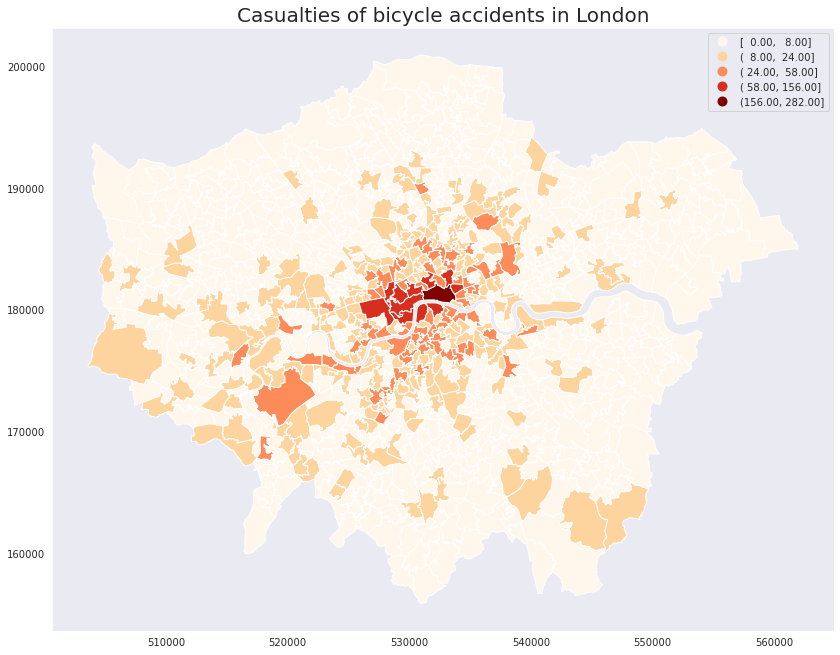

In [22]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='casualties_num', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Casualties of bicycle accidents in London',size=20)
plt.savefig('casualties_sum.png', bbox_inches = 'tight')

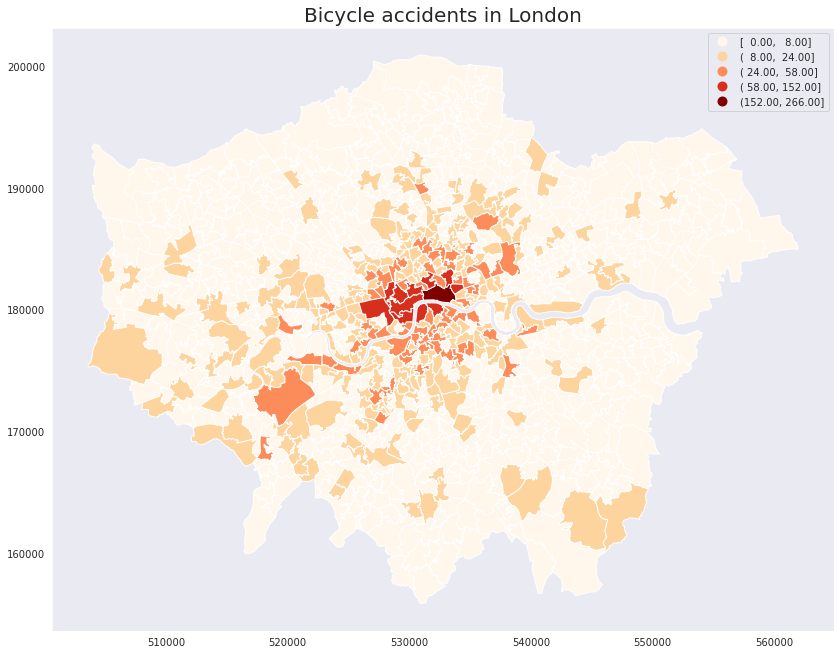

In [23]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='accidents_num', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Bicycle accidents in London',size=20)
plt.savefig('accidents_sum.png', bbox_inches = 'tight')

epsg:27700


<AxesSubplot:>

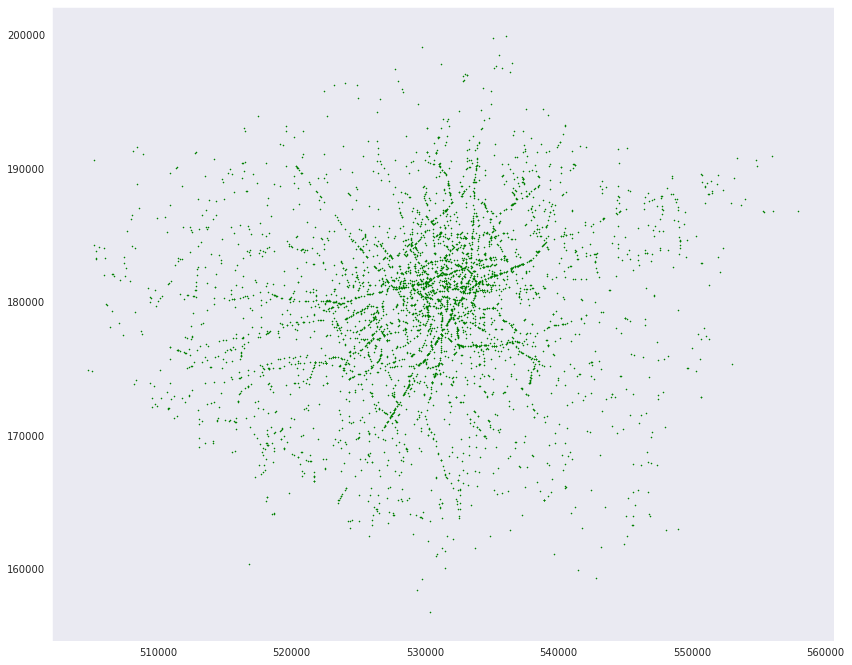

In [24]:
print(gdf.geometry.crs)
gdf.plot(figsize=(14,12), marker='*', color='green', markersize=0.25)

## Infrastructures (Point)

### Signal

In [25]:
with gzip.open(cache_data('https://github.com/hongsliu/sdc/raw/main/signal.json.gz', ddir), 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))
gdf_sig = gpd.GeoDataFrame.from_features(data["features"],crs='epsg:4326')
gdf_sig = gdf_sig.to_crs('epsg:27700')
gdf_sig.info()

data/raw/signal.json.gz not found, downloading!
	Done downloading...
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    443 non-null    geometry
 1   FEATURE_ID  443 non-null    object  
 2   SVDATE      443 non-null    object  
 3   SIG_HEAD    443 non-null    object  
 4   SIG_SEPARA  443 non-null    object  
 5   SIG_EARLY   443 non-null    object  
 6   SIG_TWOSTG  443 non-null    object  
 7   SIG_GATE    443 non-null    object  
 8   BOROUGH     443 non-null    object  
 9   PHOTO1_URL  443 non-null    object  
 10  PHOTO2_URL  443 non-null    object  
dtypes: geometry(1), object(10)
memory usage: 38.2+ KB


In [26]:
msoadf_sig  = gpd.sjoin(gdf_sig.reset_index(), 
            msoas, op='within')
msoagrdf_sig = msoadf_sig.groupby('MSOA11NM').agg({'geometry':['count']}).reset_index()
msoagrdf_sig.columns = msoagrdf_sig.columns.get_level_values(0)
msoagrdf_sig.rename(columns={"geometry": "signal_num"},inplace=True)
msoagrdf_sig.sort_values(by='signal_num', ascending=False).head(10)

MSOA11NM  signal_num
13  City of London 001          59
98     Westminster 020          37
96     Westminster 018          25
64       Southwark 034          24
52         Lambeth 036          19
11          Camden 026          11
66   Tower Hamlets 004           9
57       Southwark 002           9
73   Tower Hamlets 015           8
93     Westminster 015           7

In [27]:
#msoa_gdf.drop('signal_num_r',axis=1, inplace=True)

In [28]:
msoa_gdf = msoa_gdf.join(
                msoagrdf_sig.set_index('MSOA11NM'), 
                rsuffix='_r').fillna(0)
msoa_gdf.head(3)

OBJECTID   MSOA11CD   BNG_E   BNG_N  \
MSOA11NM                                                        
City of London 001               1  E02000001  532384  181355   
Barking and Dagenham 001         2  E02000002  548267  189685   
Barking and Dagenham 002         3  E02000003  548259  188520   

                                       Borough          msoa11hclnm  \
MSOA11NM                                                              
City of London 001              City of London       City of London   
Barking and Dagenham 001  Barking and Dagenham           Marks Gate   
Barking and Dagenham 002  Barking and Dagenham  Chadwell Heath East   

                                                                   geometry  \
MSOA11NM                                                                      
City of London 001        POLYGON ((532135.138 182198.131, 532158.250 18...   
Barking and Dagenham 001  POLYGON ((548881.563 190845.265, 548881.125 19...   
Barking and Dagenham 002  POLYGON ((549102.438 189324.625, 548954.517 18...   

                          casualties_num  accidents_num  signal_num  
MSOA11NM                                                             
City of London 001                 282.0          266.0        59.0  
Barking and Dagenham 001             2.0            2.0         0.0  
Barking and Dagenham 002            16.0           16.0         0.0

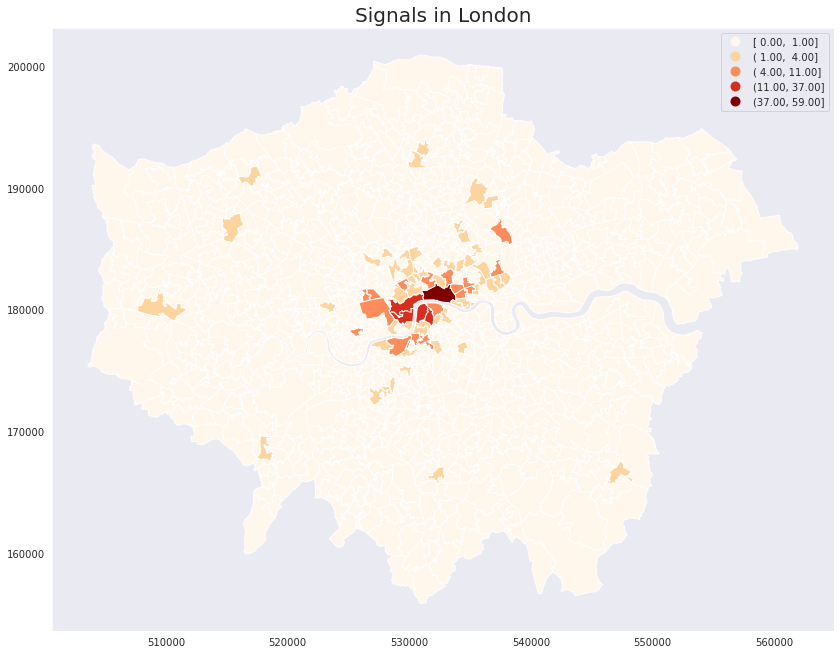

In [29]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='signal_num', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Signals in London',size=20)
plt.savefig('signal_sum.png', bbox_inches = 'tight')

epsg:27700


<AxesSubplot:>

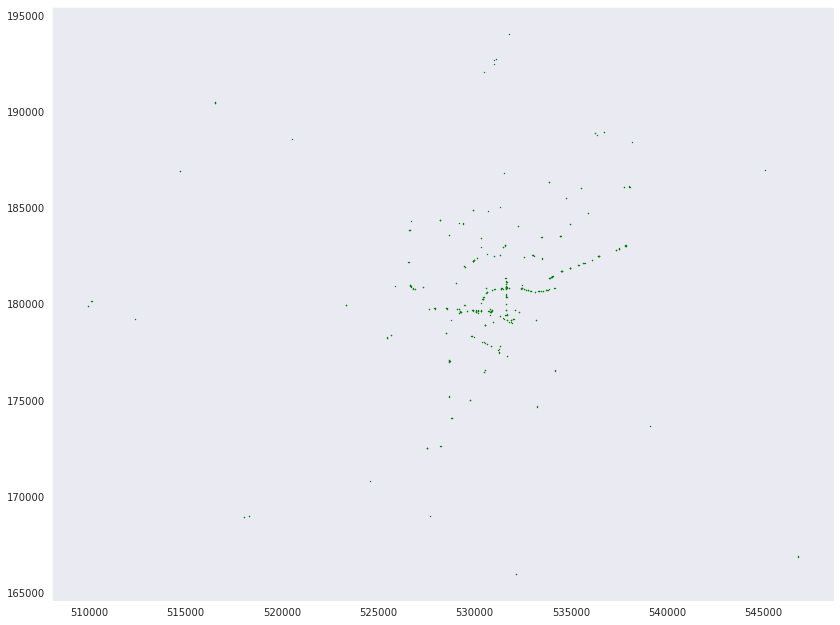

In [30]:
print(gdf_sig.geometry.crs)
gdf_sig.plot(figsize=(14,12), marker='*', color='green', markersize=0.25)

### Traffic Claming

In [31]:
with gzip.open(cache_data('https://github.com/hongsliu/sdc/raw/main/traffic_calming.json.gz', ddir), 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))
gdf_tra = gpd.GeoDataFrame.from_features(data["features"],crs='epsg:4326')
gdf_tra = gdf_tra.to_crs('epsg:27700')
gdf_tra.info()

data/raw/traffic_calming.json.gz not found, downloading!
	Done downloading...
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58565 entries, 0 to 58564
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    58565 non-null  geometry
 1   FEATURE_ID  58565 non-null  object  
 2   SVDATE      58565 non-null  object  
 3   TRF_RAISED  58565 non-null  object  
 4   TRF_ENTRY   58565 non-null  object  
 5   TRF_CUSHI   58565 non-null  object  
 6   TRF_HUMP    58565 non-null  object  
 7   TRF_SINUSO  58565 non-null  object  
 8   TRF_BARIER  58565 non-null  object  
 9   TRF_NAROW   58565 non-null  object  
 10  TRF_CALM    58565 non-null  object  
 11  BOROUGH     58565 non-null  object  
 12  PHOTO1_URL  58565 non-null  object  
 13  PHOTO2_URL  58565 non-null  object  
dtypes: geometry(1), object(13)
memory usage: 6.3+ MB


In [32]:
msoadf_tra  = gpd.sjoin(gdf_tra.reset_index(), 
            msoas, op='within')
msoagrdf_tra = msoadf_tra.groupby('MSOA11NM').agg({'geometry':['count']}).reset_index()
msoagrdf_tra.columns = msoagrdf_tra.columns.get_level_values(0)
msoagrdf_tra.rename(columns={"geometry": "traffic_calming_num"},inplace=True)
msoagrdf_tra.sort_values(by='traffic_calming_num', ascending=False).head(10)

MSOA11NM  traffic_calming_num
363         Hackney 021                  203
833       Southwark 031                  186
191  City of London 001                  181
911  Waltham Forest 019                  176
835       Southwark 033                  171
822       Southwark 020                  168
820       Southwark 018                  166
369         Hackney 027                  162
821       Southwark 019                  162
224         Croydon 034                  158

In [33]:
msoa_gdf = msoa_gdf.join(
                msoagrdf_tra.set_index('MSOA11NM'), 
                rsuffix='_r').fillna(0)
msoa_gdf.head(3)

OBJECTID   MSOA11CD   BNG_E   BNG_N  \
MSOA11NM                                                        
City of London 001               1  E02000001  532384  181355   
Barking and Dagenham 001         2  E02000002  548267  189685   
Barking and Dagenham 002         3  E02000003  548259  188520   

                                       Borough          msoa11hclnm  \
MSOA11NM                                                              
City of London 001              City of London       City of London   
Barking and Dagenham 001  Barking and Dagenham           Marks Gate   
Barking and Dagenham 002  Barking and Dagenham  Chadwell Heath East   

                                                                   geometry  \
MSOA11NM                                                                      
City of London 001        POLYGON ((532135.138 182198.131, 532158.250 18...   
Barking and Dagenham 001  POLYGON ((548881.563 190845.265, 548881.125 19...   
Barking and Dagenham 002  POLYGON ((549102.438 189324.625, 548954.517 18...   

                          casualties_num  accidents_num  signal_num  \
MSOA11NM                                                              
City of London 001                 282.0          266.0        59.0   
Barking and Dagenham 001             2.0            2.0         0.0   
Barking and Dagenham 002            16.0           16.0         0.0   

                          traffic_calming_num  
MSOA11NM                                       
City of London 001                      181.0  
Barking and Dagenham 001                 70.0  
Barking and Dagenham 002                 90.0

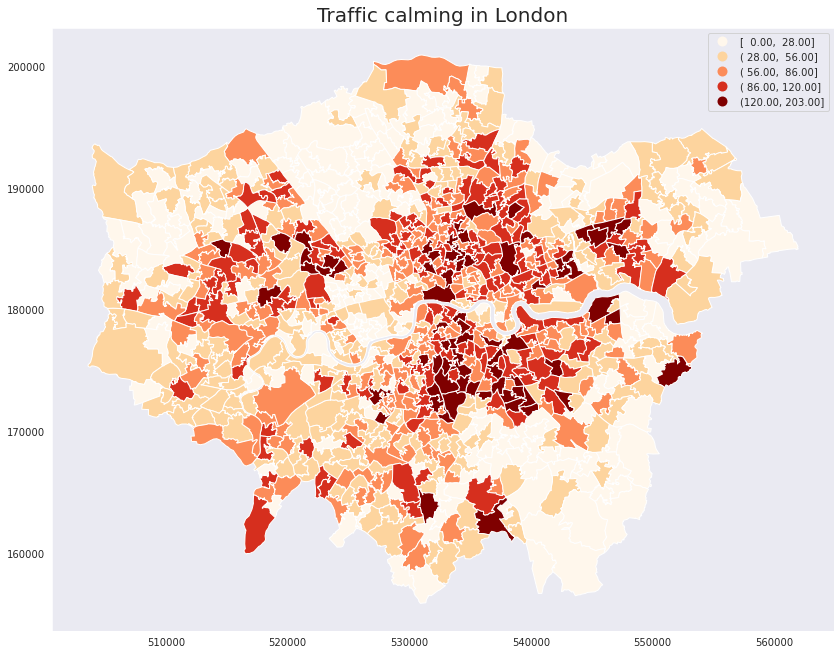

In [34]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='traffic_calming_num', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Traffic calming in London',size=20)
plt.savefig('tra_sum.png', bbox_inches = 'tight')

epsg:27700


<AxesSubplot:>

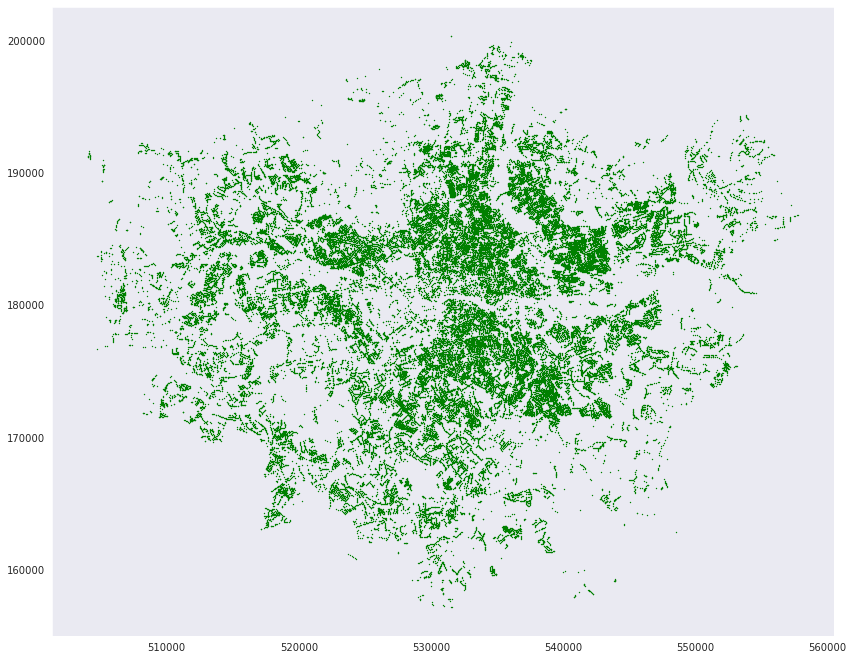

In [35]:
print(gdf_tra.geometry.crs)
gdf_tra.plot(figsize=(14,12), marker='*', color='green', markersize=0.25)

### Cycle Parking

In [36]:
with gzip.open(cache_data('https://github.com/hongsliu/sdc/raw/main/cycle_parking.json.gz', ddir), 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))
gdf_par = gpd.GeoDataFrame.from_features(data["features"],crs='epsg:4326')
gdf_par = gdf_par.to_crs('epsg:27700')
gdf_par.info()

data/raw/cycle_parking.json.gz not found, downloading!
	Done downloading...
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23758 entries, 0 to 23757
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    23758 non-null  geometry
 1   FEATURE_ID  23758 non-null  object  
 2   SVDATE      23758 non-null  object  
 3   PRK_CARR    23758 non-null  object  
 4   PRK_COVER   23758 non-null  object  
 5   PRK_SECURE  23758 non-null  object  
 6   PRK_LOCKER  23758 non-null  object  
 7   PRK_SHEFF   23758 non-null  object  
 8   PRK_MSTAND  23758 non-null  object  
 9   PRK_PSTAND  23758 non-null  object  
 10  PRK_HOOP    23758 non-null  object  
 11  PRK_POST    23758 non-null  object  
 12  PRK_BUTERF  23758 non-null  object  
 13  PRK_WHEEL   23758 non-null  object  
 14  PRK_HANGAR  23758 non-null  object  
 15  PRK_TIER    23758 non-null  object  
 16  PRK_OTHER   23758 non-null  object  
 17  PRK_

In [37]:
msoadf_par  = gpd.sjoin(gdf_par.reset_index(), 
            msoas, op='within')
msoagrdf_par = msoadf_par.groupby('MSOA11NM').agg({'geometry':['count']}).reset_index()
msoagrdf_par.columns = msoagrdf_par.columns.get_level_values(0)
msoagrdf_par.rename(columns={"geometry": "parking_num"},inplace=True)
msoagrdf_par.sort_values(by='parking_num', ascending=False).head(10)

MSOA11NM  parking_num
183  City of London 001          307
182          Camden 028          271
358         Hackney 027          269
951     Westminster 013          258
956     Westminster 018          244
180          Camden 026          198
559       Islington 022          191
788       Southwark 002          191
345         Hackney 014          167
351         Hackney 020          163

In [38]:
msoa_gdf = msoa_gdf.join(
                msoagrdf_par.set_index('MSOA11NM'), 
                rsuffix='_r').fillna(0)
msoa_gdf.head(3)

OBJECTID   MSOA11CD   BNG_E   BNG_N  \
MSOA11NM                                                        
City of London 001               1  E02000001  532384  181355   
Barking and Dagenham 001         2  E02000002  548267  189685   
Barking and Dagenham 002         3  E02000003  548259  188520   

                                       Borough          msoa11hclnm  \
MSOA11NM                                                              
City of London 001              City of London       City of London   
Barking and Dagenham 001  Barking and Dagenham           Marks Gate   
Barking and Dagenham 002  Barking and Dagenham  Chadwell Heath East   

                                                                   geometry  \
MSOA11NM                                                                      
City of London 001        POLYGON ((532135.138 182198.131, 532158.250 18...   
Barking and Dagenham 001  POLYGON ((548881.563 190845.265, 548881.125 19...   
Barking and Dagenham 002  POLYGON ((549102.438 189324.625, 548954.517 18...   

                          casualties_num  accidents_num  signal_num  \
MSOA11NM                                                              
City of London 001                 282.0          266.0        59.0   
Barking and Dagenham 001             2.0            2.0         0.0   
Barking and Dagenham 002            16.0           16.0         0.0   

                          traffic_calming_num  parking_num  
MSOA11NM                                                    
City of London 001                      181.0        307.0  
Barking and Dagenham 001                 70.0          9.0  
Barking and Dagenham 002                 90.0         15.0

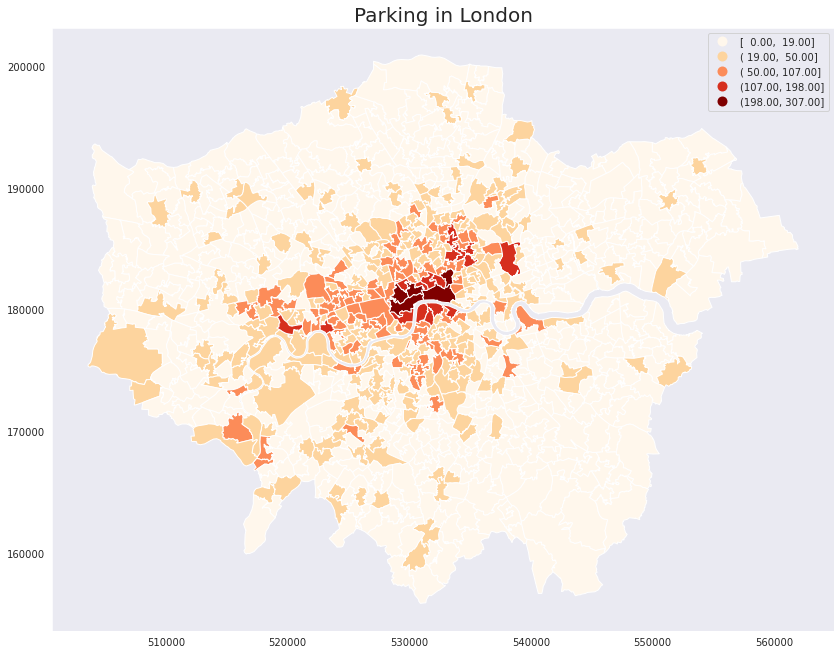

In [39]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='parking_num', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Parking in London',size=20)
plt.savefig('parking_sum.png', bbox_inches = 'tight')

epsg:27700


<AxesSubplot:>

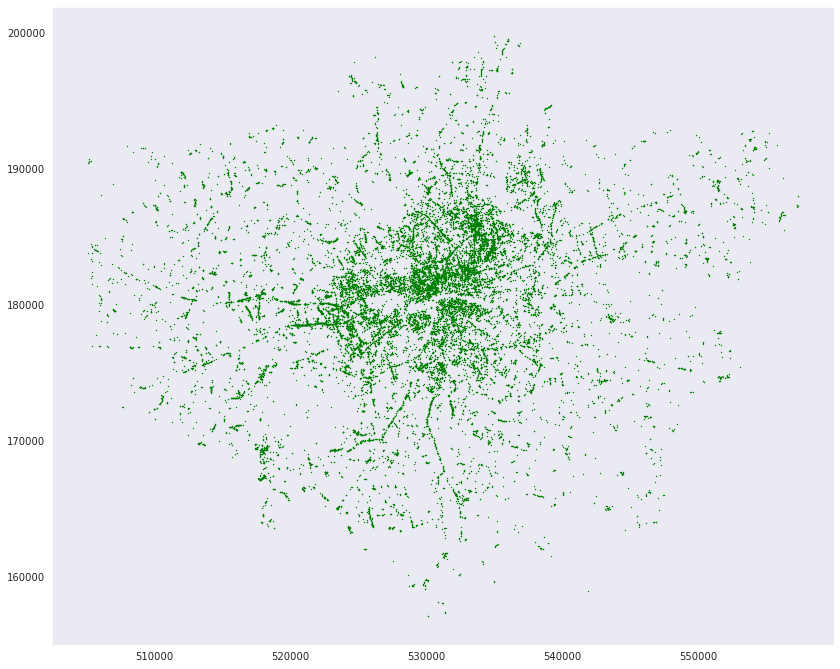

In [40]:
print(gdf_par.geometry.crs)
gdf_par.plot(figsize=(14,12), marker='*', color='green', markersize=0.25)

### Restricted Point

In [41]:
with gzip.open(cache_data('https://github.com/hongsliu/sdc/raw/main/restricted_point.json.gz', ddir), 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))
gdf_res = gpd.GeoDataFrame.from_features(data["features"],crs='epsg:4326')
gdf_res = gdf_res.to_crs('epsg:27700')
gdf_res.info()

data/raw/restricted_point.json.gz not found, downloading!
	Done downloading...
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    180 non-null    geometry
 1   FEATURE_ID  180 non-null    object  
 2   SVDATE      180 non-null    object  
 3   RST_STEPS   180 non-null    object  
 4   RST_LIFT    180 non-null    object  
 5   BOROUGH     180 non-null    object  
 6   PHOTO1_URL  180 non-null    object  
 7   PHOTO2_URL  180 non-null    object  
dtypes: geometry(1), object(7)
memory usage: 11.4+ KB


In [42]:
msoadf_res  = gpd.sjoin(gdf_sig.reset_index(), 
            msoas, op='within')
msoagrdf_res = msoadf_res.groupby('MSOA11NM').agg({'geometry':['count']}).reset_index()
msoagrdf_res.columns = msoagrdf_res.columns.get_level_values(0)
msoagrdf_res.rename(columns={"geometry": "restricted_point_num"},inplace=True)
msoagrdf_res.sort_values(by='restricted_point_num', ascending=False).head(10)

MSOA11NM  restricted_point_num
13  City of London 001                    59
98     Westminster 020                    37
96     Westminster 018                    25
64       Southwark 034                    24
52         Lambeth 036                    19
11          Camden 026                    11
66   Tower Hamlets 004                     9
57       Southwark 002                     9
73   Tower Hamlets 015                     8
93     Westminster 015                     7

In [43]:
msoa_gdf = msoa_gdf.join(
                msoagrdf_res.set_index('MSOA11NM'), 
                rsuffix='_r').fillna(0)
msoa_gdf.head(3)

OBJECTID   MSOA11CD   BNG_E   BNG_N  \
MSOA11NM                                                        
City of London 001               1  E02000001  532384  181355   
Barking and Dagenham 001         2  E02000002  548267  189685   
Barking and Dagenham 002         3  E02000003  548259  188520   

                                       Borough          msoa11hclnm  \
MSOA11NM                                                              
City of London 001              City of London       City of London   
Barking and Dagenham 001  Barking and Dagenham           Marks Gate   
Barking and Dagenham 002  Barking and Dagenham  Chadwell Heath East   

                                                                   geometry  \
MSOA11NM                                                                      
City of London 001        POLYGON ((532135.138 182198.131, 532158.250 18...   
Barking and Dagenham 001  POLYGON ((548881.563 190845.265, 548881.125 19...   
Barking and Dagenham 002  POLYGON ((549102.438 189324.625, 548954.517 18...   

                          casualties_num  accidents_num  signal_num  \
MSOA11NM                                                              
City of London 001                 282.0          266.0        59.0   
Barking and Dagenham 001             2.0            2.0         0.0   
Barking and Dagenham 002            16.0           16.0         0.0   

                          traffic_calming_num  parking_num  \
MSOA11NM                                                     
City of London 001                      181.0        307.0   
Barking and Dagenham 001                 70.0          9.0   
Barking and Dagenham 002                 90.0         15.0   

                          restricted_point_num  
MSOA11NM                                        
City of London 001                        59.0  
Barking and Dagenham 001                   0.0  
Barking and Dagenham 002                   0.0

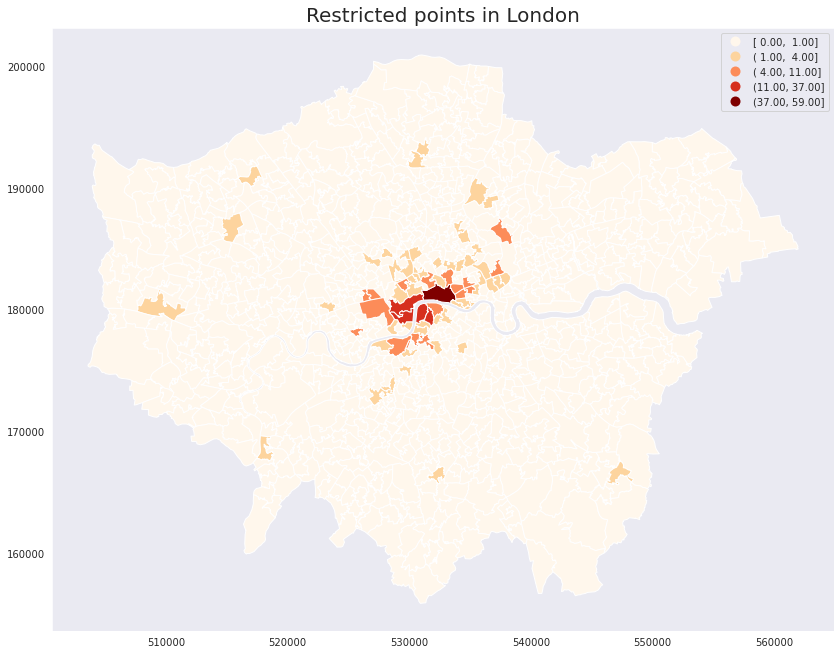

In [44]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='restricted_point_num', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Restricted points in London',size=20)
plt.savefig('restricted_point_sum.png', bbox_inches = 'tight')

epsg:27700


<AxesSubplot:>

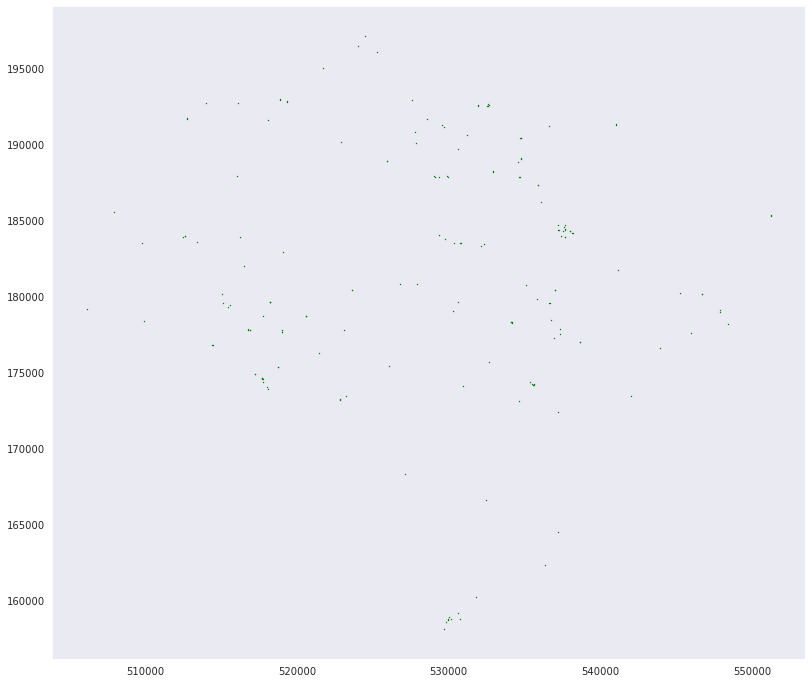

In [45]:
print(gdf_res.geometry.crs)
gdf_res.plot(figsize=(14,12), marker='*', color='green', markersize=0.25)

## Infrastructures (Line)

### Cycle lane

In [46]:
with gzip.open(cache_data('https://github.com/hongsliu/sdc/raw/main/cycle_lane_track.json.gz', ddir), 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))

data/raw/cycle_lane_track.json.gz not found, downloading!
	Done downloading...


In [47]:
gdf_lane = gpd.GeoDataFrame.from_features(data["features"],crs='epsg:4326')
gdf_lane = gdf_lane.to_crs('epsg:27700')
gdf_lane.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24976 entries, 0 to 24975
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    24976 non-null  geometry
 1   FEATURE_ID  24976 non-null  object  
 2   SVDATE      24976 non-null  object  
 3   CLT_CARR    24976 non-null  object  
 4   CLT_SEGREG  24976 non-null  object  
 5   CLT_STEPP   24976 non-null  object  
 6   CLT_PARSEG  24976 non-null  object  
 7   CLT_SHARED  24976 non-null  object  
 8   CLT_MANDAT  24976 non-null  object  
 9   CLT_ADVIS   24976 non-null  object  
 10  CLT_PRIORI  24976 non-null  object  
 11  CLT_CONTRA  24976 non-null  object  
 12  CLT_BIDIRE  24976 non-null  object  
 13  CLT_CBYPAS  24976 non-null  object  
 14  CLT_BBYPAS  24976 non-null  object  
 15  CLT_PARKR   24976 non-null  object  
 16  CLT_WATERR  24976 non-null  object  
 17  CLT_PTIME   24976 non-null  object  
 18  CLT_ACCESS  2916 non-null   object  
 

In [48]:
gdf_lane['length']=gdf_lane['geometry'].length
gdf_lane.head()

geometry FEATURE_ID      SVDATE  \
0  LINESTRING (548080.696 188023.228, 547952.800 ...  RWG154837  2017-10-14   
1  LINESTRING (547843.339 187947.851, 547801.207 ...  RWG154839  2017-10-14   
2  LINESTRING (548111.690 186872.973, 548079.354 ...  RWG154848  2017-10-14   
3  LINESTRING (548526.492 188122.505, 548486.721 ...  RWG154853  2017-10-15   
4  LINESTRING (548504.573 186639.905, 548492.439 ...  RWG155003  2017-10-17   

  CLT_CARR CLT_SEGREG CLT_STEPP CLT_PARSEG CLT_SHARED CLT_MANDAT CLT_ADVIS  \
0     TRUE      FALSE     FALSE      FALSE      FALSE      FALSE      TRUE   
1     TRUE      FALSE     FALSE      FALSE      FALSE      FALSE      TRUE   
2     TRUE      FALSE     FALSE      FALSE      FALSE      FALSE      TRUE   
3     TRUE      FALSE     FALSE      FALSE      FALSE      FALSE      TRUE   
4     TRUE      FALSE     FALSE      FALSE      FALSE       TRUE     FALSE   

   ... CLT_BBYPAS CLT_PARKR CLT_WATERR CLT_PTIME CLT_ACCESS CLT_COLOUR  \
0  ...      FALSE     FALSE      FALSE     FALSE       None       NONE   
1  ...      FALSE     FALSE      FALSE     FALSE       None       NONE   
2  ...      FALSE     FALSE      FALSE     FALSE       None       NONE   
3  ...      FALSE     FALSE      FALSE     FALSE       None       NONE   
4  ...      FALSE     FALSE      FALSE     FALSE       None       NONE   

              BOROUGH                                         PHOTO1_URL  \
0  Barking & Dagenham  https://cycleassetimages.data.tfl.gov.uk/RWG15...   
1  Barking & Dagenham  https://cycleassetimages.data.tfl.gov.uk/RWG15...   
2  Barking & Dagenham  https://cycleassetimages.data.tfl.gov.uk/RWG15...   
3  Barking & Dagenham  https://cycleassetimages.data.tfl.gov.uk/RWG15...   
4  Barking & Dagenham  https://cycleassetimages.data.tfl.gov.uk/RWG15...   

                                          PHOTO2_URL      length  
0  https://cycleassetimages.data.tfl.gov.uk/RWG15...  134.240613  
1  https://cycleassetimages.data.tfl.gov.uk/RWG15...   85.310122  
2  https://cycleassetimages.data.tfl.gov.uk/RWG15...  251.131588  
3  https://cycleassetimages.data.tfl.gov.uk/RWG15...  142.592121  
4  https://cycleassetimages.data.tfl.gov.uk/RWG15...   24.695457  

[5 rows x 24 columns]

In [49]:
msoadf_lane  = gpd.sjoin(gdf_lane.reset_index(), 
            msoas, op='within')
msoagrdf_lane = msoadf_lane.groupby('MSOA11NM').agg({'length':['sum']}).reset_index()
msoagrdf_lane.columns = msoagrdf_lane.columns.get_level_values(0)
msoagrdf_lane.rename(columns={"length": "lane_len"},inplace=True)
msoagrdf_lane.sort_values(by='lane_len', ascending=False).head(10)

MSOA11NM      lane_len
703          Newham 013  37394.099857
503      Hillingdon 031  21409.395231
185  City of London 001  19746.173869
949     Westminster 019  18339.047447
303       Greenwich 002  17249.454691
126         Bromley 005  13482.541915
747       Redbridge 027  10508.166211
330       Greenwich 036  10448.723872
838   Tower Hamlets 003  10402.645274
631         Lambeth 036  10198.819178

In [50]:
msoa_gdf = msoa_gdf.join(
                msoagrdf_lane.set_index('MSOA11NM'), 
                rsuffix='_r').fillna(0)
msoa_gdf['lane_den'] = msoa_gdf['lane_len']/msoa_gdf.geometry.area
msoa_gdf.head(3)

OBJECTID   MSOA11CD   BNG_E   BNG_N  \
MSOA11NM                                                        
City of London 001               1  E02000001  532384  181355   
Barking and Dagenham 001         2  E02000002  548267  189685   
Barking and Dagenham 002         3  E02000003  548259  188520   

                                       Borough          msoa11hclnm  \
MSOA11NM                                                              
City of London 001              City of London       City of London   
Barking and Dagenham 001  Barking and Dagenham           Marks Gate   
Barking and Dagenham 002  Barking and Dagenham  Chadwell Heath East   

                                                                   geometry  \
MSOA11NM                                                                      
City of London 001        POLYGON ((532135.138 182198.131, 532158.250 18...   
Barking and Dagenham 001  POLYGON ((548881.563 190845.265, 548881.125 19...   
Barking and Dagenham 002  POLYGON ((549102.438 189324.625, 548954.517 18...   

                          casualties_num  accidents_num  signal_num  \
MSOA11NM                                                              
City of London 001                 282.0          266.0        59.0   
Barking and Dagenham 001             2.0            2.0         0.0   
Barking and Dagenham 002            16.0           16.0         0.0   

                          traffic_calming_num  parking_num  \
MSOA11NM                                                     
City of London 001                      181.0        307.0   
Barking and Dagenham 001                 70.0          9.0   
Barking and Dagenham 002                 90.0         15.0   

                          restricted_point_num      lane_len  lane_den  
MSOA11NM                                                                
City of London 001                        59.0  19746.173869  0.006794  
Barking and Dagenham 001                   0.0   2696.225417  0.001245  
Barking and Dagenham 002                   0.0   5578.625837  0.002602

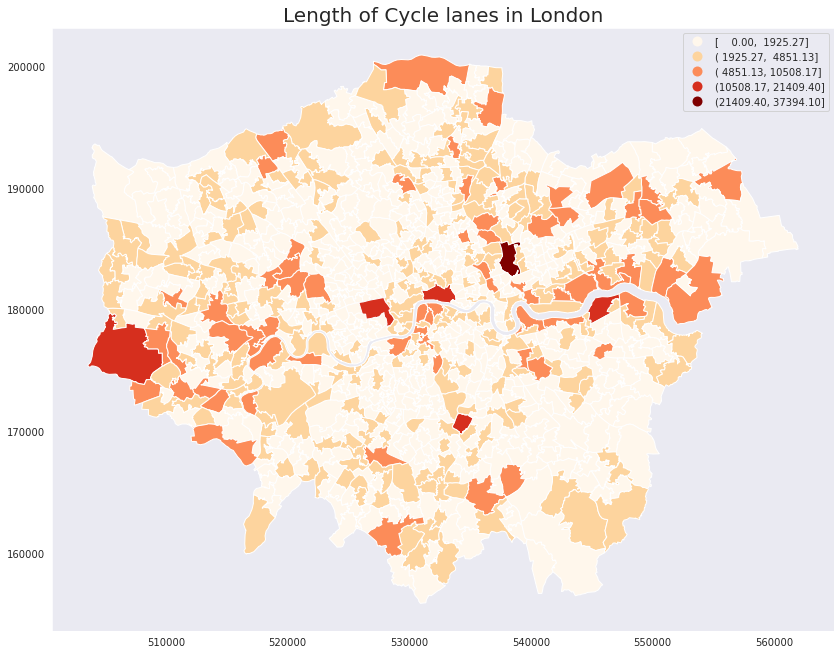

In [51]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='lane_len', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Length of Cycle lanes in London',size=20)
plt.savefig('lane_len.png', bbox_inches = 'tight')

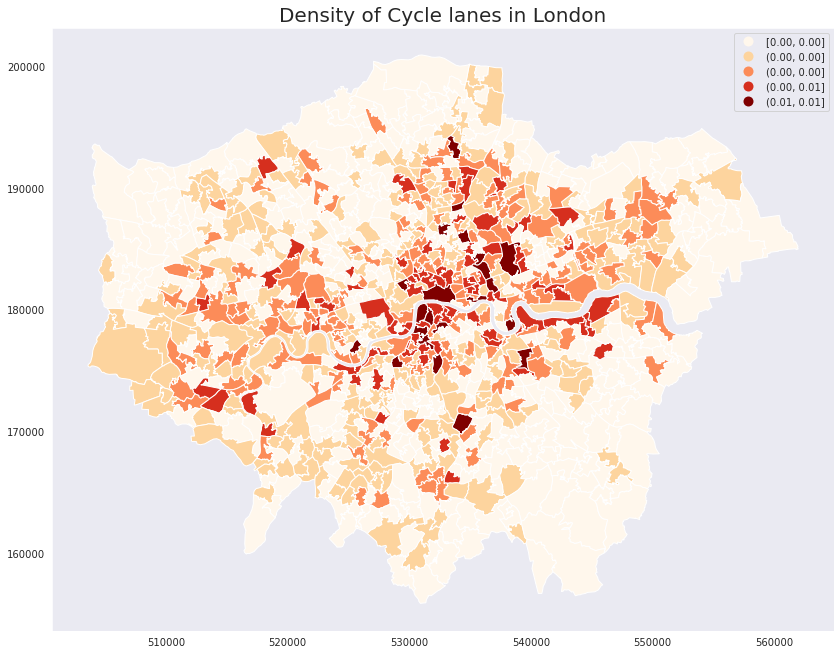

In [52]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='lane_den', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Density of Cycle lanes in London',size=20)
plt.savefig('lane_den.png', bbox_inches = 'tight')

epsg:27700


<AxesSubplot:>

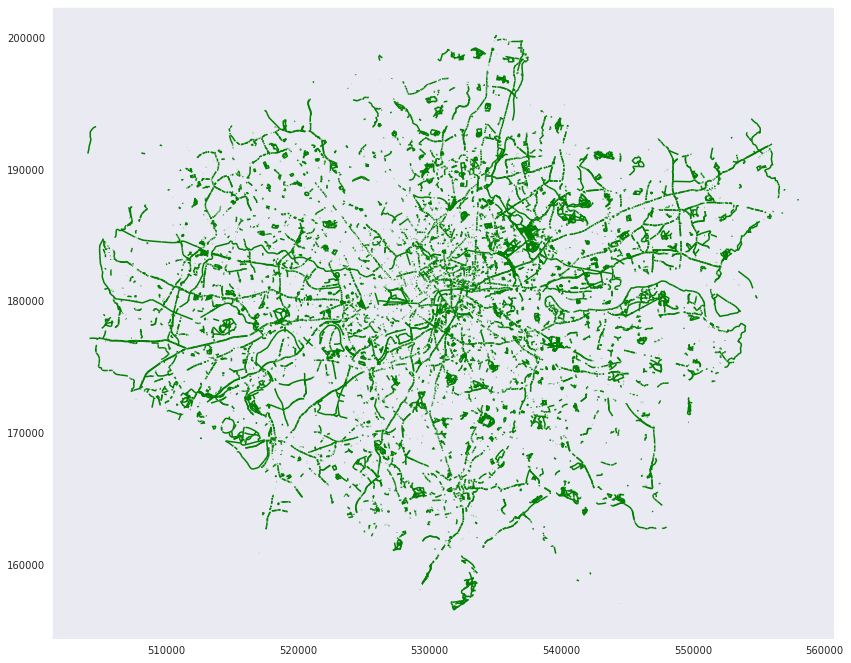

In [53]:
print(gdf_lane.geometry.crs)
gdf_lane.plot(figsize=(14,12),  color='green')

### Advanced stop line

In [54]:
with gzip.open(cache_data('https://github.com/hongsliu/sdc/raw/main/advanced_stop_line.json.gz', ddir), 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))
gdf_stop = gpd.GeoDataFrame.from_features(data["features"],crs='epsg:4326')
gdf_stop = gdf_stop.to_crs('epsg:27700')
print(gdf_stop.info())

data/raw/advanced_stop_line.json.gz not found, downloading!
	Done downloading...
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3775 entries, 0 to 3774
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    3775 non-null   geometry
 1   FEATURE_ID  3775 non-null   object  
 2   SVDATE      3775 non-null   object  
 3   ASL_FDR     3775 non-null   object  
 4   ASL_FDRLFT  3775 non-null   object  
 5   ASL_FDCENT  3775 non-null   object  
 6   ASL_FDRIGH  3775 non-null   object  
 7   ASL_SHARED  3775 non-null   object  
 8   ASL_COLOUR  3775 non-null   object  
 9   BOROUGH     3774 non-null   object  
 10  PHOTO1_URL  3775 non-null   object  
 11  PHOTO2_URL  3775 non-null   object  
dtypes: geometry(1), object(11)
memory usage: 354.0+ KB
None


In [55]:
msoadf_stop  = gpd.sjoin(gdf_stop.reset_index(), 
            msoas, op='within')
msoagrdf_stop = msoadf_stop.groupby('MSOA11NM').agg({'geometry':['count']}).reset_index()
msoagrdf_stop.columns = msoagrdf_stop.columns.get_level_values(0)
msoagrdf_stop.rename(columns={"geometry": "stop_num"},inplace=True)
msoagrdf_stop.sort_values(by='stop_num', ascending=False).head(10)

MSOA11NM  stop_num
79   City of London 001       121
440          Newham 013        53
78           Camden 028        39
491       Southwark 002        36
190         Hackney 027        33
386         Lambeth 036        31
94          Croydon 028        28
319       Islington 022        28
586      Wandsworth 002        25
634     Westminster 018        24

In [56]:
sum(msoagrdf_stop.stop_num)

3748

In [57]:
msoa_gdf = msoa_gdf.join(
                msoagrdf_stop.set_index('MSOA11NM'), 
                rsuffix='_r').fillna(0)
msoa_gdf.head(3)

OBJECTID   MSOA11CD   BNG_E   BNG_N  \
MSOA11NM                                                        
City of London 001               1  E02000001  532384  181355   
Barking and Dagenham 001         2  E02000002  548267  189685   
Barking and Dagenham 002         3  E02000003  548259  188520   

                                       Borough          msoa11hclnm  \
MSOA11NM                                                              
City of London 001              City of London       City of London   
Barking and Dagenham 001  Barking and Dagenham           Marks Gate   
Barking and Dagenham 002  Barking and Dagenham  Chadwell Heath East   

                                                                   geometry  \
MSOA11NM                                                                      
City of London 001        POLYGON ((532135.138 182198.131, 532158.250 18...   
Barking and Dagenham 001  POLYGON ((548881.563 190845.265, 548881.125 19...   
Barking and Dagenham 002  POLYGON ((549102.438 189324.625, 548954.517 18...   

                          casualties_num  accidents_num  signal_num  \
MSOA11NM                                                              
City of London 001                 282.0          266.0        59.0   
Barking and Dagenham 001             2.0            2.0         0.0   
Barking and Dagenham 002            16.0           16.0         0.0   

                          traffic_calming_num  parking_num  \
MSOA11NM                                                     
City of London 001                      181.0        307.0   
Barking and Dagenham 001                 70.0          9.0   
Barking and Dagenham 002                 90.0         15.0   

                          restricted_point_num      lane_len  lane_den  \
MSOA11NM                                                                 
City of London 001                        59.0  19746.173869  0.006794   
Barking and Dagenham 001                   0.0   2696.225417  0.001245   
Barking and Dagenham 002                   0.0   5578.625837  0.002602   

                          stop_num  
MSOA11NM                            
City of London 001           121.0  
Barking and Dagenham 001       3.0  
Barking and Dagenham 002      10.0

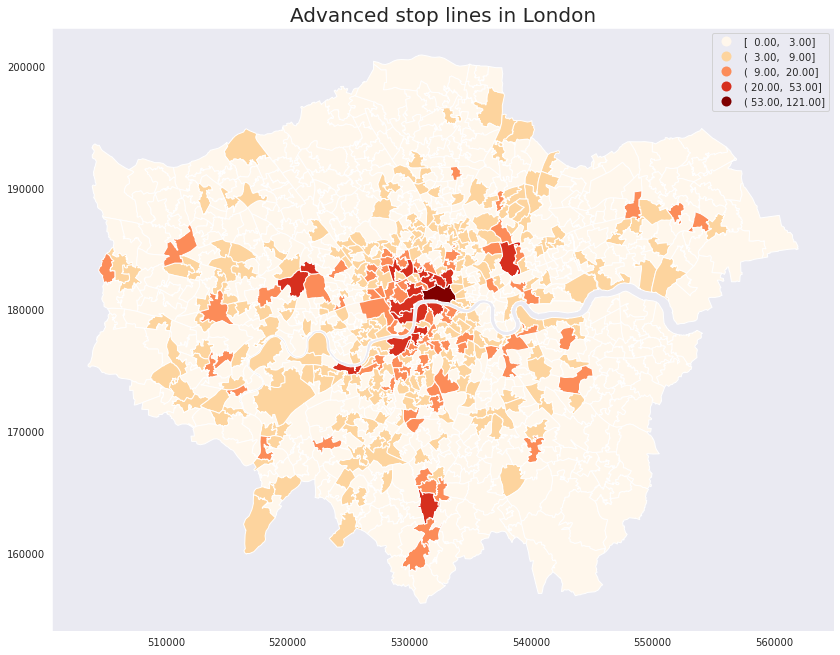

In [58]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='stop_num', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Advanced stop lines in London',size=20)
plt.savefig('stop_sum.png', bbox_inches = 'tight')

epsg:27700


<AxesSubplot:>

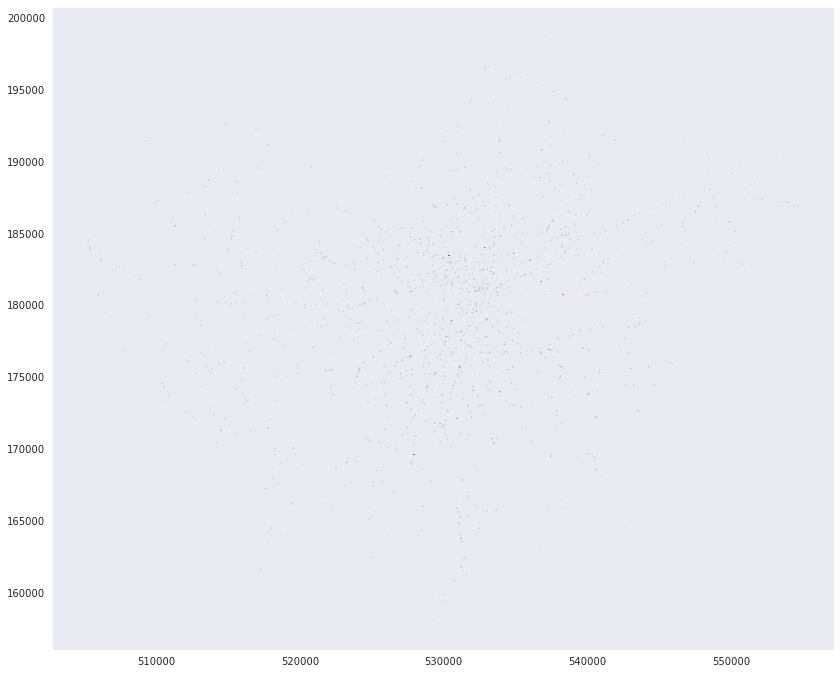

In [59]:
print(gdf_stop.geometry.crs)
gdf_stop.plot(figsize=(14,12),  color='green')

### Crossing

In [60]:
with gzip.open(cache_data('https://github.com/hongsliu/sdc/raw/main/crossing.json.gz', ddir), 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))
gdf_cross = gpd.GeoDataFrame.from_features(data["features"],crs='epsg:4326')
gdf_cross = gdf_cross.to_crs('epsg:27700')
print(gdf_cross.info())

data/raw/crossing.json.gz not found, downloading!
	Done downloading...
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1687 entries, 0 to 1686
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    1687 non-null   geometry
 1   FEATURE_ID  1687 non-null   object  
 2   SVDATE      1687 non-null   object  
 3   CRS_SIGNAL  1687 non-null   object  
 4   CRS_SEGREG  1687 non-null   object  
 5   CRS_CYGAP   1687 non-null   object  
 6   CRS_PEDEST  1687 non-null   object  
 7   CRS_LEVEL   1687 non-null   object  
 8   BOROUGH     1659 non-null   object  
 9   PHOTO1_URL  1687 non-null   object  
 10  PHOTO2_URL  1687 non-null   object  
dtypes: geometry(1), object(10)
memory usage: 145.1+ KB
None


In [61]:
msoadf_cross  = gpd.sjoin(gdf_cross.reset_index(), 
            msoas, op='within')
msoagrdf_cross = msoadf_cross.groupby('MSOA11NM').agg({'geometry':['count']}).reset_index()
msoagrdf_cross.columns = msoagrdf_cross.columns.get_level_values(0)
msoagrdf_cross.rename(columns={"geometry": "cross_num"},inplace=True)
msoagrdf_cross.sort_values(by='cross_num', ascending=False).head(10)

MSOA11NM  cross_num
294                  Newham 013         36
303                  Newham 033         28
206              Hillingdon 031         21
139                 Hackney 018         20
351               Southwark 034         19
188                Havering 028         18
246    Kingston upon Thames 009         17
202              Hillingdon 027         15
147  Hammersmith and Fulham 013         15
375           Tower Hamlets 028         15

In [62]:
sum(msoagrdf_cross.cross_num)

1441

In [63]:
msoa_gdf = msoa_gdf.join(
                msoagrdf_cross.set_index('MSOA11NM'), 
                rsuffix='_r').fillna(0)
msoa_gdf.head(3)

OBJECTID   MSOA11CD   BNG_E   BNG_N  \
MSOA11NM                                                        
City of London 001               1  E02000001  532384  181355   
Barking and Dagenham 001         2  E02000002  548267  189685   
Barking and Dagenham 002         3  E02000003  548259  188520   

                                       Borough          msoa11hclnm  \
MSOA11NM                                                              
City of London 001              City of London       City of London   
Barking and Dagenham 001  Barking and Dagenham           Marks Gate   
Barking and Dagenham 002  Barking and Dagenham  Chadwell Heath East   

                                                                   geometry  \
MSOA11NM                                                                      
City of London 001        POLYGON ((532135.138 182198.131, 532158.250 18...   
Barking and Dagenham 001  POLYGON ((548881.563 190845.265, 548881.125 19...   
Barking and Dagenham 002  POLYGON ((549102.438 189324.625, 548954.517 18...   

                          casualties_num  accidents_num  signal_num  \
MSOA11NM                                                              
City of London 001                 282.0          266.0        59.0   
Barking and Dagenham 001             2.0            2.0         0.0   
Barking and Dagenham 002            16.0           16.0         0.0   

                          traffic_calming_num  parking_num  \
MSOA11NM                                                     
City of London 001                      181.0        307.0   
Barking and Dagenham 001                 70.0          9.0   
Barking and Dagenham 002                 90.0         15.0   

                          restricted_point_num      lane_len  lane_den  \
MSOA11NM                                                                 
City of London 001                        59.0  19746.173869  0.006794   
Barking and Dagenham 001                   0.0   2696.225417  0.001245   
Barking and Dagenham 002                   0.0   5578.625837  0.002602   

                          stop_num  cross_num  
MSOA11NM                                       
City of London 001           121.0       13.0  
Barking and Dagenham 001       3.0        1.0  
Barking and Dagenham 002      10.0        1.0

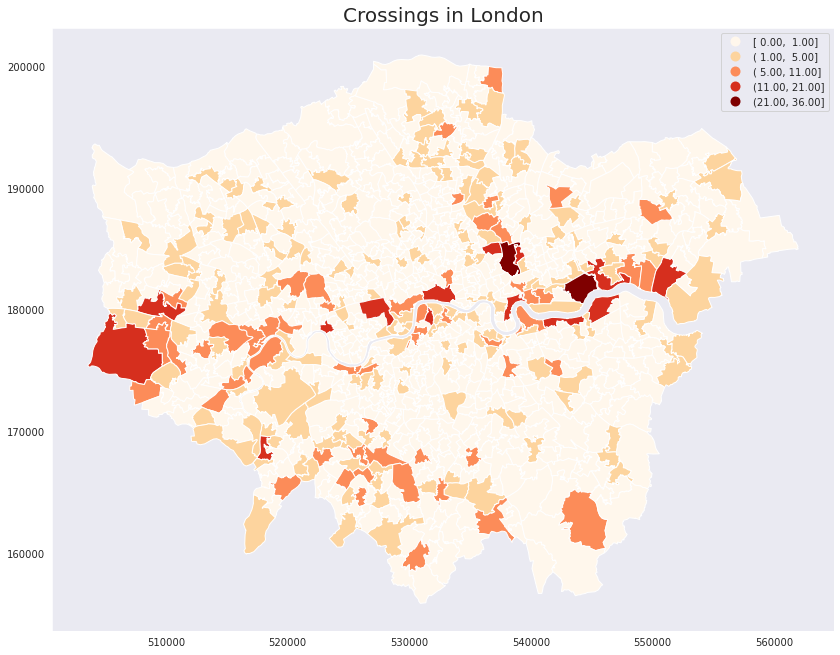

In [64]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='cross_num', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Crossings in London',size=20)
plt.savefig('cross_sum.png', bbox_inches = 'tight')

epsg:27700


<AxesSubplot:>

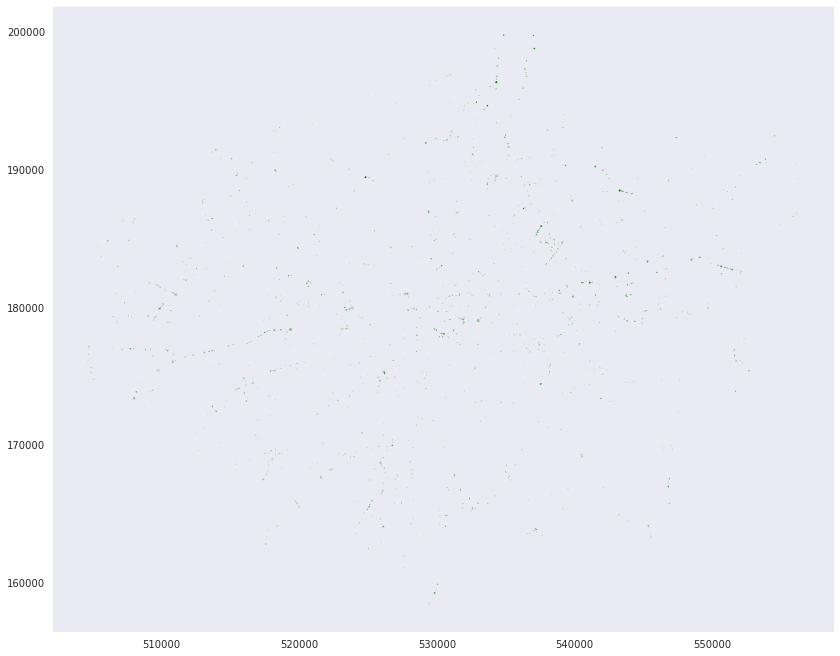

In [65]:
print(gdf_cross.geometry.crs)
gdf_cross.plot(figsize=(14,12),  color='green')

### Restricted routes

In [66]:
with gzip.open(cache_data('https://github.com/hongsliu/sdc/raw/main/restricted_route.json.gz', ddir), 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))
gdf_rest = gpd.GeoDataFrame.from_features(data["features"],crs='epsg:4326')
gdf_rest = gdf_rest.to_crs('epsg:27700')
gdf_rest['length']=gdf_rest.geometry.length
gdf_rest.info()

data/raw/restricted_route.json.gz not found, downloading!
	Done downloading...
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    1378 non-null   geometry
 1   FEATURE_ID  1378 non-null   object  
 2   SVDATE      1378 non-null   object  
 3   RES_PEDEST  1378 non-null   object  
 4   RES_BRIDGE  1378 non-null   object  
 5   RES_TUNNEL  1378 non-null   object  
 6   RES_STEPS   1378 non-null   object  
 7   RES_LIFT    1378 non-null   object  
 8   BOROUGH     1360 non-null   object  
 9   PHOTO1_URL  1378 non-null   object  
 10  PHOTO2_URL  1378 non-null   object  
 11  length      1378 non-null   float64 
dtypes: float64(1), geometry(1), object(10)
memory usage: 129.3+ KB


In [67]:
msoadf_rest  = gpd.sjoin(gdf_rest.reset_index(), 
            msoas, op='within')
msoagrdf_rest = msoadf_rest.groupby('MSOA11NM').agg({'length':['sum']}).reset_index()
msoagrdf_rest.columns = msoagrdf_rest.columns.get_level_values(0)
msoagrdf_rest.rename(columns={"length": "restricted_routes_len"},inplace=True)
msoagrdf_rest.sort_values(by='restricted_routes_len', ascending=False).head(10)

MSOA11NM  restricted_routes_len
66        Camden 002            8275.228095
65        Camden 001            8036.886570
244   Hillingdon 032            6262.435812
50         Brent 032            3566.878042
54       Bromley 012            3236.325650
236   Hillingdon 023            3077.947273
189     Haringey 031            2874.214103
312    Redbridge 035            2711.624274
309    Redbridge 014            1658.966820
393  Westminster 010            1534.021219

In [68]:
msoa_gdf = msoa_gdf.join(
                msoagrdf_rest.set_index('MSOA11NM'), 
                rsuffix='_r').fillna(0)
msoa_gdf['restricted_routes_den']=msoa_gdf['restricted_routes_len']/msoa_gdf.geometry.area
msoa_gdf.head(3)

OBJECTID   MSOA11CD   BNG_E   BNG_N  \
MSOA11NM                                                        
City of London 001               1  E02000001  532384  181355   
Barking and Dagenham 001         2  E02000002  548267  189685   
Barking and Dagenham 002         3  E02000003  548259  188520   

                                       Borough          msoa11hclnm  \
MSOA11NM                                                              
City of London 001              City of London       City of London   
Barking and Dagenham 001  Barking and Dagenham           Marks Gate   
Barking and Dagenham 002  Barking and Dagenham  Chadwell Heath East   

                                                                   geometry  \
MSOA11NM                                                                      
City of London 001        POLYGON ((532135.138 182198.131, 532158.250 18...   
Barking and Dagenham 001  POLYGON ((548881.563 190845.265, 548881.125 19...   
Barking and Dagenham 002  POLYGON ((549102.438 189324.625, 548954.517 18...   

                          casualties_num  accidents_num  signal_num  \
MSOA11NM                                                              
City of London 001                 282.0          266.0        59.0   
Barking and Dagenham 001             2.0            2.0         0.0   
Barking and Dagenham 002            16.0           16.0         0.0   

                          traffic_calming_num  parking_num  \
MSOA11NM                                                     
City of London 001                      181.0        307.0   
Barking and Dagenham 001                 70.0          9.0   
Barking and Dagenham 002                 90.0         15.0   

                          restricted_point_num      lane_len  lane_den  \
MSOA11NM                                                                 
City of London 001                        59.0  19746.173869  0.006794   
Barking and Dagenham 001                   0.0   2696.225417  0.001245   
Barking and Dagenham 002                   0.0   5578.625837  0.002602   

                          stop_num  cross_num  restricted_routes_len  \
MSOA11NM                                                               
City of London 001           121.0       13.0             427.791541   
Barking and Dagenham 001       3.0        1.0               0.000000   
Barking and Dagenham 002      10.0        1.0               0.000000   

                          restricted_routes_den  
MSOA11NM                                         
City of London 001                     0.000147  
Barking and Dagenham 001               0.000000  
Barking and Dagenham 002               0.000000

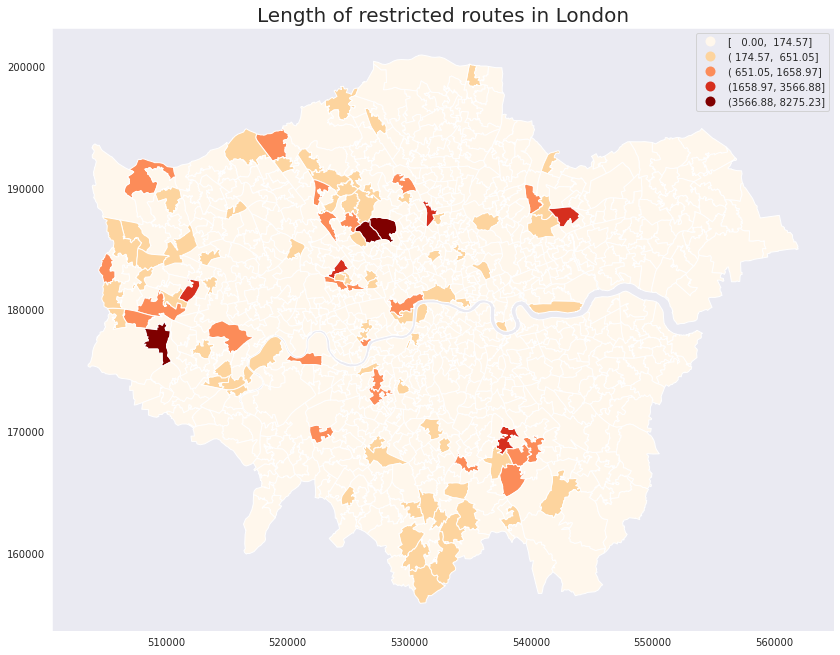

In [69]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='restricted_routes_len', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Length of restricted routes in London',size=20)
plt.savefig('restricted_routes_len.png', bbox_inches = 'tight')

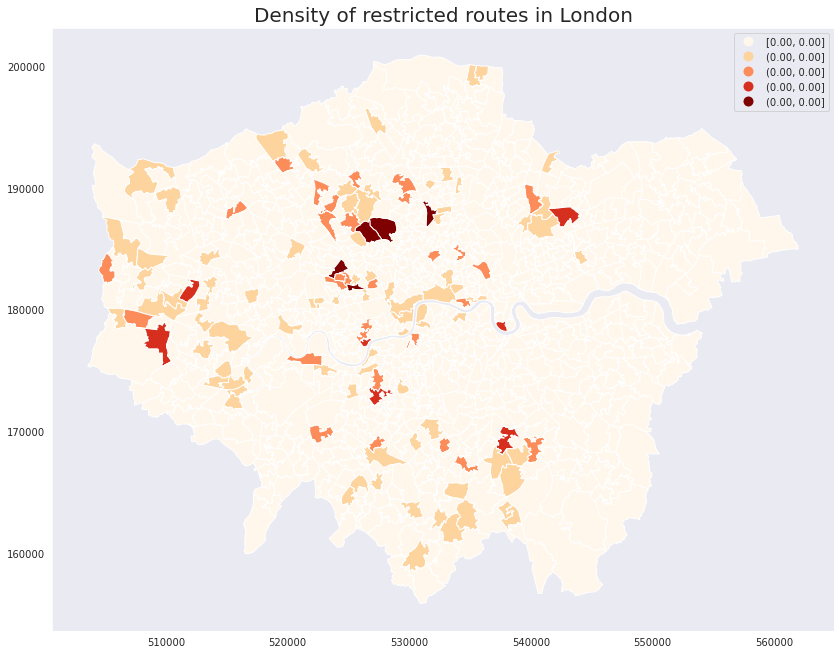

In [70]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='restricted_routes_den', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Density of restricted routes in London',size=20)
plt.savefig('restricted_routes_den.png', bbox_inches = 'tight')

epsg:27700


<AxesSubplot:>

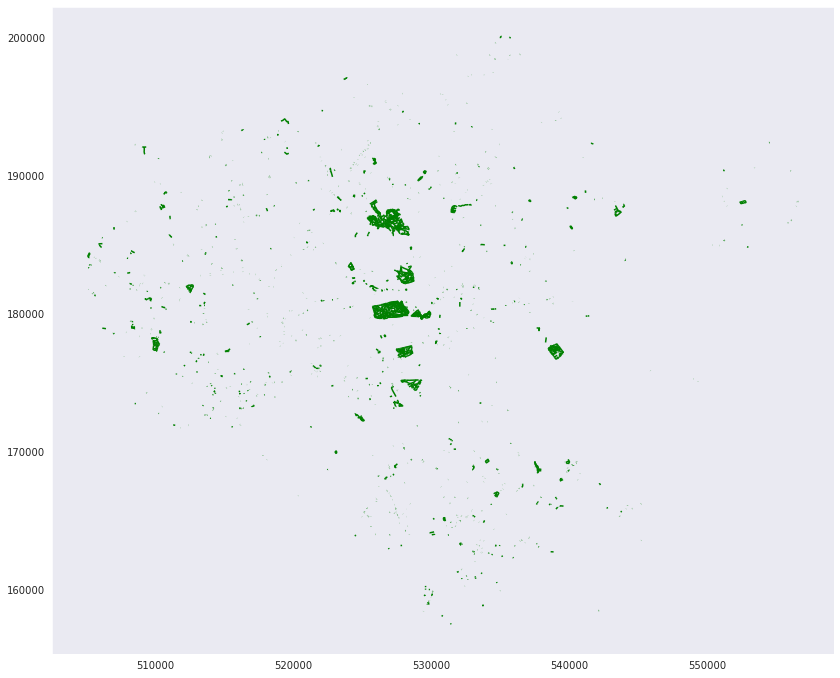

In [71]:
print(gdf_rest.geometry.crs)
gdf_rest.plot(figsize=(14,12),  color='green')

## Spatial autocorrelation

In [72]:
import sys
!{sys.executable} -m pip install pysal
!{sys.executable} -m pip install splot
!{sys.executable} -m pip install esda
#!{sys.executable} -m pip install -U esda

In [73]:
import pysal
from libpysal import weights
from esda.moran import Moran, Moran_Local
from esda import getisord, geary
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster

In [74]:
msoa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 983 entries, City of London 001 to Greenwich 038
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   OBJECTID               983 non-null    int64   
 1   MSOA11CD               983 non-null    object  
 2   BNG_E                  983 non-null    int64   
 3   BNG_N                  983 non-null    int64   
 4   Borough                983 non-null    object  
 5   msoa11hclnm            983 non-null    object  
 6   geometry               983 non-null    geometry
 7   casualties_num         983 non-null    float64 
 8   accidents_num          983 non-null    float64 
 9   signal_num             983 non-null    float64 
 10  traffic_calming_num    983 non-null    float64 
 11  parking_num            983 non-null    float64 
 12  restricted_point_num   983 non-null    float64 
 13  lane_len               983 non-null    float64 
 14  lane_den    

In [75]:
w = weights.Queen.from_dataframe(msoa_gdf, idVariable="MSOA11CD" )
w.transform = "R"

In [76]:
msoa_gdf["w_casualties_num"] = weights.lag_spatial(w, msoa_gdf["casualties_num"])

In [77]:
y = msoa_gdf["casualties_num"]
moran = Moran(y, w)
moran.I

0.5669826078857201

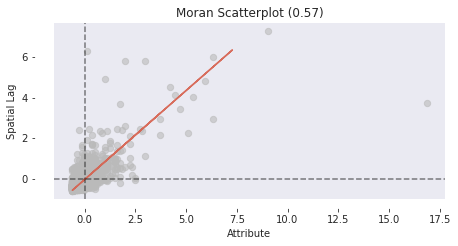

In [78]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [79]:
m_local = Moran_Local(y, w)

In [80]:
p=0.05
sig = 1 * (m_local.p_sim < p)
HH = 1 * (sig * m_local.q == 1)
LL = 3 * (sig * m_local.q == 3)
LH = 2 * (sig * m_local.q == 2)
HL = 4 * (sig * m_local.q == 4)
cluster = HH + LL + LH + HL
cluster

array([1, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 3, 0, 3, 3, 3, 0,
       0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3,
       0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0,

In [81]:
msoa_gdf['casualties_auto']=cluster

<AxesSubplot:>

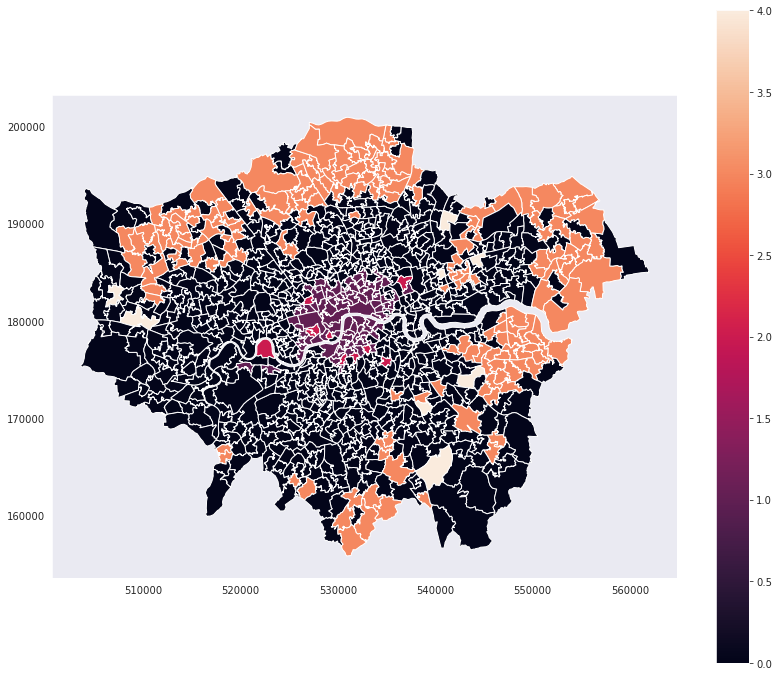

In [82]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='casualties_auto', ax=axes, legend=True)

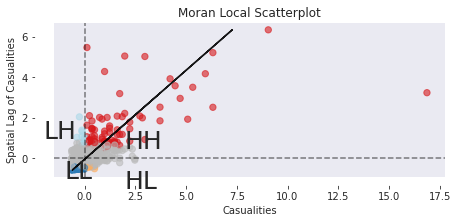

In [83]:
fig, ax = moran_scatterplot(m_local, p=0.05)
ax.set_xlabel("Casualities")
ax.set_ylabel('Spatial Lag of Casualities')
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

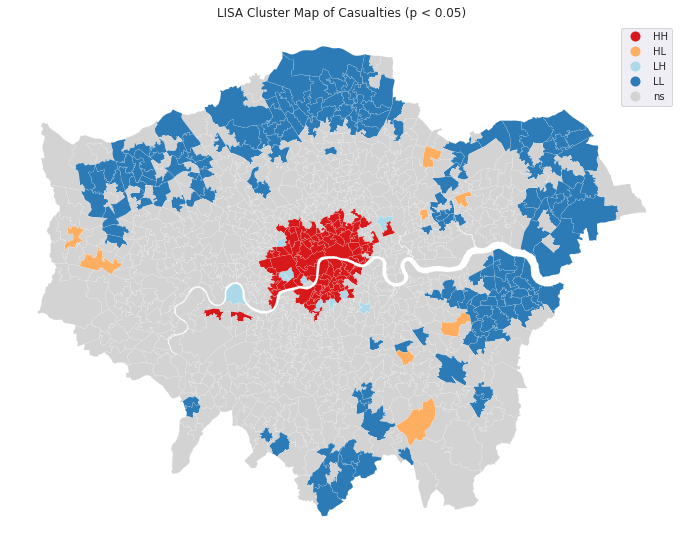

In [84]:
lisa_cluster(m_local, msoa_gdf, p=0.05, figsize = (12,12))
plt.title("LISA Cluster Map of Casualties (p < 0.05)")
plt.savefig('casualties_auto.png', bbox_inches = 'tight')
plt.show()

In [85]:
msoa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 983 entries, City of London 001 to Greenwich 038
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   OBJECTID               983 non-null    int64   
 1   MSOA11CD               983 non-null    object  
 2   BNG_E                  983 non-null    int64   
 3   BNG_N                  983 non-null    int64   
 4   Borough                983 non-null    object  
 5   msoa11hclnm            983 non-null    object  
 6   geometry               983 non-null    geometry
 7   casualties_num         983 non-null    float64 
 8   accidents_num          983 non-null    float64 
 9   signal_num             983 non-null    float64 
 10  traffic_calming_num    983 non-null    float64 
 11  parking_num            983 non-null    float64 
 12  restricted_point_num   983 non-null    float64 
 13  lane_len               983 non-null    float64 
 14  lane_den    

## Clustering Analysis

In [86]:
msoa_gdf.head()

OBJECTID   MSOA11CD   BNG_E   BNG_N  \
MSOA11NM                                                        
City of London 001               1  E02000001  532384  181355   
Barking and Dagenham 001         2  E02000002  548267  189685   
Barking and Dagenham 002         3  E02000003  548259  188520   
Barking and Dagenham 003         4  E02000004  551004  186412   
Barking and Dagenham 004         5  E02000005  548733  186824   

                                       Borough          msoa11hclnm  \
MSOA11NM                                                              
City of London 001              City of London       City of London   
Barking and Dagenham 001  Barking and Dagenham           Marks Gate   
Barking and Dagenham 002  Barking and Dagenham  Chadwell Heath East   
Barking and Dagenham 003  Barking and Dagenham         Eastbrookend   
Barking and Dagenham 004  Barking and Dagenham      Becontree Heath   

                                                                   geometry  \
MSOA11NM                                                                      
City of London 001        POLYGON ((532135.138 182198.131, 532158.250 18...   
Barking and Dagenham 001  POLYGON ((548881.563 190845.265, 548881.125 19...   
Barking and Dagenham 002  POLYGON ((549102.438 189324.625, 548954.517 18...   
Barking and Dagenham 003  POLYGON ((551550.056 187364.705, 551478.000 18...   
Barking and Dagenham 004  POLYGON ((549099.634 187656.076, 549161.375 18...   

                          casualties_num  accidents_num  signal_num  ...  \
MSOA11NM                                                             ...   
City of London 001                 282.0          266.0        59.0  ...   
Barking and Dagenham 001             2.0            2.0         0.0  ...   
Barking and Dagenham 002            16.0           16.0         0.0  ...   
Barking and Dagenham 003             0.0            0.0         0.0  ...   
Barking and Dagenham 004             4.0            4.0         0.0  ...   

                          parking_num  restricted_point_num      lane_len  \
MSOA11NM                                                                    
City of London 001              307.0                  59.0  19746.173869   
Barking and Dagenham 001          9.0                   0.0   2696.225417   
Barking and Dagenham 002         15.0                   0.0   5578.625837   
Barking and Dagenham 003          3.0                   0.0   2817.474199   
Barking and Dagenham 004         19.0                   0.0   2163.753828   

                          lane_den  stop_num  cross_num  \
MSOA11NM                                                  
City of London 001        0.006794     121.0       13.0   
Barking and Dagenham 001  0.001245       3.0        1.0   
Barking and Dagenham 002  0.002602      10.0        1.0   
Barking and Dagenham 003  0.001131       0.0        0.0   
Barking and Dagenham 004  0.001824       7.0        0.0   

                          restricted_routes_len  restricted_routes_den  \
MSOA11NM                                                                 
City of London 001                   427.791541               0.000147   
Barking and Dagenham 001               0.000000               0.000000   
Barking and Dagenham 002               0.000000               0.000000   
Barking and Dagenham 003               0.000000               0.000000   
Barking and Dagenham 004               0.000000               0.000000   

                          w_casualties_num  casualties_auto  
MSOA11NM                                                     
City of London 001               70.400000                1  
Barking and Dagenham 001          4.666667                0  
Barking and Dagenham 002          4.857143                0  
Barking and Dagenham 003          2.400000                3  
Barking and Dagenham 004          8.000000                0  

[5 rows x 21 columns]

In [87]:
#house_price = pd.read_csv( cache_data('https://raw.githubusercontent.com/hongsliu/sdc/main/median_house_price_18.csv', ddir),
#    low_memory=False).set_index('MSOA code')
#population = pd.read_csv( cache_data('https://raw.githubusercontent.com/hongsliu/sdc/main/population.csv', ddir),
#    low_memory=False).set_index('Area Codes')
cycling = pd.read_csv( cache_data('https://raw.githubusercontent.com/hongsliu/sdc/main/london_cycling.csv', ddir),
    low_memory=False).set_index('geo_code1')

data/raw/london_cycling.csv not found, downloading!
	Done downloading...


In [88]:
msoa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 983 entries, City of London 001 to Greenwich 038
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   OBJECTID               983 non-null    int64   
 1   MSOA11CD               983 non-null    object  
 2   BNG_E                  983 non-null    int64   
 3   BNG_N                  983 non-null    int64   
 4   Borough                983 non-null    object  
 5   msoa11hclnm            983 non-null    object  
 6   geometry               983 non-null    geometry
 7   casualties_num         983 non-null    float64 
 8   accidents_num          983 non-null    float64 
 9   signal_num             983 non-null    float64 
 10  traffic_calming_num    983 non-null    float64 
 11  parking_num            983 non-null    float64 
 12  restricted_point_num   983 non-null    float64 
 13  lane_len               983 non-null    float64 
 14  lane_den    

In [89]:
msoa_gdf = msoa_gdf.reset_index().set_index('MSOA11CD')
#msoa_gdf = pd.merge(msoa_gdf, house_price, left_index=True, right_index=True)
#msoa_gdf = pd.merge(msoa_gdf, population, left_index=True, right_index=True)
msoa_gdf = pd.merge(msoa_gdf, cycling, left_index=True, right_index=True)

In [90]:
#msoa_gdf['median_house_price_2018'] = msoa_gdf.median_house_price_2018.astype(str).str.replace(',','').astype(float)
#msoa_gdf['population'] = msoa_gdf.population.astype(str).str.replace(',','').astype(float)
msoa_gdf['origin_ratio'] = msoa_gdf.origin_ratio.astype(str).str.replace('%','').astype(float)/100
msoa_gdf['destination_ratio'] = msoa_gdf.destination_ratio.astype(str).str.replace('%','').astype(float)/100
#msoa_gdf['pop_den']= msoa_gdf['population'] / (msoa_gdf['geometry'].area/ 10**6)
msoa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 982 entries, E02000001 to E02006931
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   MSOA11NM               982 non-null    object  
 1   OBJECTID               982 non-null    int64   
 2   BNG_E                  982 non-null    int64   
 3   BNG_N                  982 non-null    int64   
 4   Borough                982 non-null    object  
 5   msoa11hclnm            982 non-null    object  
 6   geometry               982 non-null    geometry
 7   casualties_num         982 non-null    float64 
 8   accidents_num          982 non-null    float64 
 9   signal_num             982 non-null    float64 
 10  traffic_calming_num    982 non-null    float64 
 11  parking_num            982 non-null    float64 
 12  restricted_point_num   982 non-null    float64 
 13  lane_len               982 non-null    float64 
 14  lane_den               98

In [91]:
msoa_gdf["infra_num"] = msoa_gdf['signal_num'] + msoa_gdf['traffic_calming_num'] + msoa_gdf['parking_num'] + msoa_gdf['stop_num'] + msoa_gdf['cross_num']

In [92]:
rs = msoa_gdf
msoa_gdf.head()

MSOA11NM  OBJECTID   BNG_E   BNG_N  \
E02000001        City of London 001         1  532384  181355   
E02000002  Barking and Dagenham 001         2  548267  189685   
E02000003  Barking and Dagenham 002         3  548259  188520   
E02000004  Barking and Dagenham 003         4  551004  186412   
E02000005  Barking and Dagenham 004         5  548733  186824   

                        Borough          msoa11hclnm  \
E02000001        City of London       City of London   
E02000002  Barking and Dagenham           Marks Gate   
E02000003  Barking and Dagenham  Chadwell Heath East   
E02000004  Barking and Dagenham         Eastbrookend   
E02000005  Barking and Dagenham      Becontree Heath   

                                                    geometry  casualties_num  \
E02000001  POLYGON ((532135.138 182198.131, 532158.250 18...           282.0   
E02000002  POLYGON ((548881.563 190845.265, 548881.125 19...             2.0   
E02000003  POLYGON ((549102.438 189324.625, 548954.517 18...            16.0   
E02000004  POLYGON ((551550.056 187364.705, 551478.000 18...             0.0   
E02000005  POLYGON ((549099.634 187656.076, 549161.375 18...             4.0   

           accidents_num  signal_num  ...  restricted_routes_den  \
E02000001          266.0        59.0  ...               0.000147   
E02000002            2.0         0.0  ...               0.000000   
E02000003           16.0         0.0  ...               0.000000   
E02000004            0.0         0.0  ...               0.000000   
E02000005            4.0         0.0  ...               0.000000   

           w_casualties_num  casualties_auto  origin_bicycle  origin_all  \
E02000001         70.400000                1             222        3657   
E02000002          4.666667                0              26        1720   
E02000003          4.857143                0              34        3349   
E02000004          2.400000                3              35        2074   
E02000005          8.000000                0              55        2616   

           origin_ratio  destination_bicycle  destination_all  \
E02000001        0.0607                12964           244502   
E02000002        0.0151                    7              516   
E02000003        0.0102                   48             2222   
E02000004        0.0169                   19              862   
E02000005        0.0210                   18              714   

           destination_ratio  infra_num  
E02000001             0.0530      681.0  
E02000002             0.0136       83.0  
E02000003             0.0216      116.0  
E02000004             0.0220       10.0  
E02000005             0.0252       76.0  

[5 rows x 28 columns]

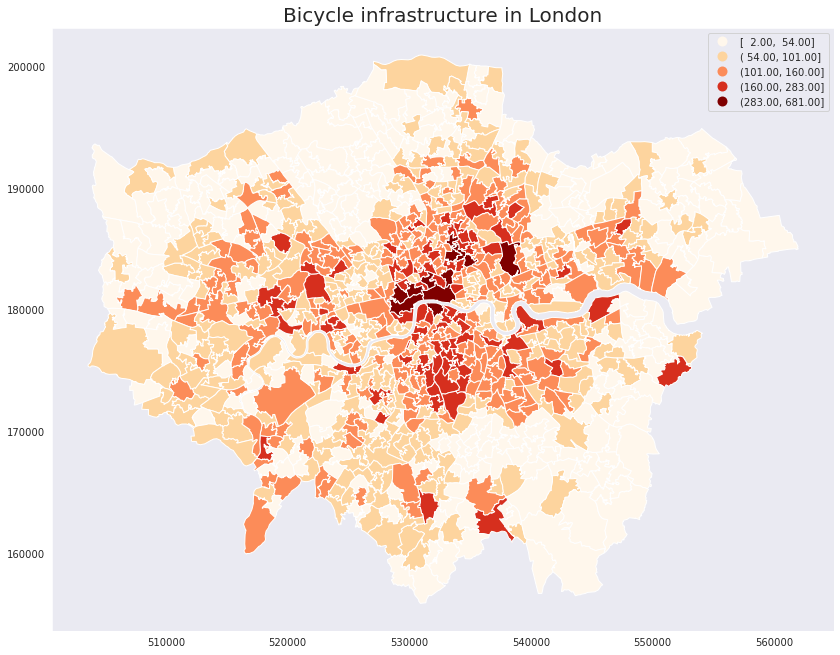

In [93]:
f,axes = plt.subplots(1,1,figsize=(14,12))
msoa_gdf.plot(column='infra_num', ax=axes, legend=True, cmap='OrRd', scheme='fisherjenks')
plt.title('Bicycle infrastructure in London',size=20)
plt.savefig('infrastructure_num.png', bbox_inches = 'tight')

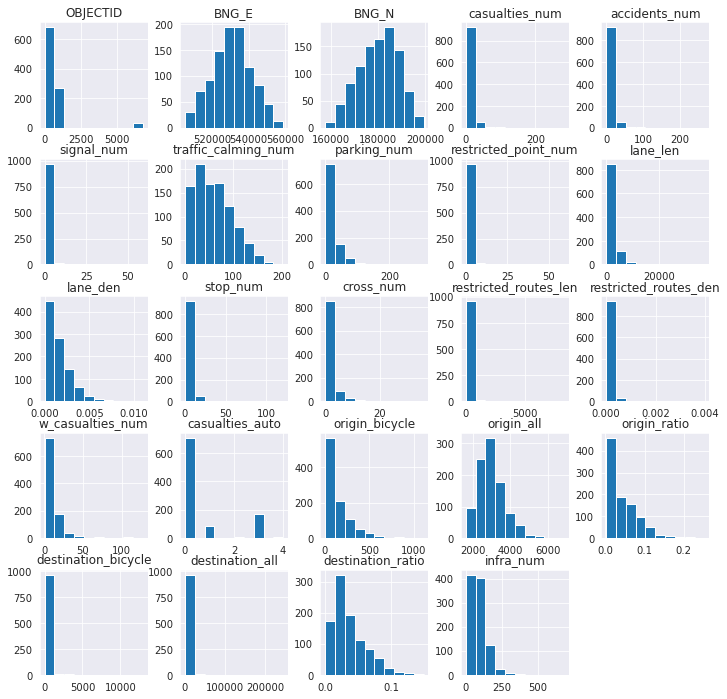

In [94]:
hist=msoa_gdf.hist(figsize=(12,12))

In [95]:
attributes=['casualties_num','lane_den','origin_ratio','destination_ratio', 'signal_num','traffic_calming_num', 
      'parking_num', 'stop_num', 'cross_num']
#var = ['casualties_num','lane_den','origin_ratio','destination_ratio', 'signal_num', 'traffic_calming_num', 
#      'parking_num', 'stop_num', 'cross_num', 'restricted_point_num', 'restricted_routes_den','infra_num']
attributes_log=[]
for i in attributes:
    msoa_gdf[f"log_{i}"] = np.log10(msoa_gdf[i]+1)
    attributes_log.append(f"log_{i}")

In [ ]:
hist=msoa_gdf.hist(figsize=(12,12),column=attributes)
plt.savefig('data_pre.png')

In [ ]:
hist=msoa_gdf.hist(figsize=(12,12),column=attributes_log)
plt.savefig('data_pre_log.png')

In [ ]:
df_c = msoa_gdf.loc[:,attributes_log]
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df_c.corr(), fignum=f.number)
plt.xticks(range(df_c.shape[1]), df_c.columns, fontsize=14, rotation=45)
plt.yticks(range(df_c.shape[1]), df_c.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.savefig('Correlation_Matrix.png')

In [ ]:
sns.set_style('white')
df_c = msoa_gdf.loc[:,attributes_log]
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(12, 12))
mask = np.zeros_like(df_c.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_c.corr(), cmap="Blues", annot=True,mask=mask)
plt.xticks(range(df_c.shape[1]), df_c.columns, fontsize=10, rotation=45)
#plt.yticks(range(df_c.shape[1]), df_c.columns, fontsize=14)

plt.title('Correlation Matrix', fontsize=16)
plt.savefig('Correlation_Matrix.png')


In [ ]:
sns.set_style('dark')

In [ ]:
# calculating VIF
# This function is partially from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
 https://moodle.ucl.ac.uk/my/   '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [ ]:
df_c_new = drop_column_using_vif_(df_c, thresh=5)

In [ ]:
df_c_new

In [ ]:
var=attributes_log
#var = ['casualties_num','lane_den','origin_ratio','destination_ratio', 'signal_num', 'traffic_calming_num', 
#      'parking_num', 'stop_num', 'cross_num', 'restricted_point_num', 'restricted_routes_den']
mms = MinMaxScaler(feature_range=(-1,1))
cldf = msoa_gdf.loc[:,var]

for c in cldf.columns:
    cldf[c] = mms.fit_transform(cldf[c].values.reshape(-1,1))
rs   = pd.merge(msoas, cldf, left_on='MSOA11CD', right_index=True).set_index('MSOA11CD')
cldf.head(2)

In [ ]:
wcss=[]
for i in range(1,10): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=31).fit(cldf)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10),wcss,marker='o')
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0, 10, step=1))
plt.ylabel('WCSS')
plt.savefig('elbow_method.png')
plt.show()

In [ ]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score
x = []
y = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=31).fit(cldf)
    silhouette_avg = silhouette_score(cldf, kmeans.labels_)
    y.append(k)
    x.append(silhouette_avg)
    print('.', end='')
print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")
plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores");
plt.savefig('silhouette score.png')

In [ ]:
rs

In [ ]:
c_nm   = 'KMeans'
k_pref=5
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=31).fit(cldf)
s = pd.Series(kmeans.labels_, index=cldf.index, name=c_nm)
rs[c_nm] = s
    

silhouette_avg = silhouette_score(cldf, kmeans.labels_)

sample_silhouette_values = silhouette_samples(cldf, kmeans.labels_)
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)
ax1.set_xlim([-1.0, 1.0]) 
ax1.set_ylim([0, cldf.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
for i in range(k_pref):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    color = plt.cm.Spectral(i/k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([]) 
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) 

    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k)
    ax2.scatter(cldf[cldf.columns[0]], cldf[cldf.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)
    
    centers = kmeans.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')

plt.show()

In [ ]:
#rs.Kmeans.astype('str')

In [ ]:
colors = {0:3, 1:0, 2:1, 3:4, 4:2}
rs['KMeans']=rs['KMeans'].apply(lambda x: colors[x])
rs.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 12))
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True,cmap='Set3',legend=True)
msoa_gdf['kmeans_results'] = rs.KMeans
plt.savefig('cluster.png', bbox_inches = 'tight')

In [ ]:
msoa_gdf_g=msoa_gdf.groupby('kmeans_results')[attributes].agg('mean')
msoa_df_g = pd.DataFrame(msoa_gdf_g)
msoa_df_g

In [ ]:
palette=[plt.cm.Set3(0),plt.cm.Set3(0.25),plt.cm.Set3(0.5),plt.cm.Set3(0.75),plt.cm.Set3(1)]

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 16),sharex=True)
msoa_gdf_g1=msoa_gdf_g.reset_index()
#axes[0,0].bar("kmeans_results","casualties_num",data=msoa_gdf_g1,color=palette)
sns.barplot(ax=axes[0, 0], data=msoa_gdf_g1, x="kmeans_results", y="casualties_num",palette=palette)
axes[0,0].set_title("casualties_num")
sns.barplot(ax=axes[0, 1], data=msoa_gdf_g1, x="kmeans_results", y="lane_den",palette=palette)
axes[0,1].set_title("lane_den")
sns.barplot(ax=axes[0, 2], data=msoa_gdf_g1, x="kmeans_results", y="origin_ratio",palette=palette)
axes[0,2].set_title("origin_ratio")
sns.barplot(ax=axes[1, 0], data=msoa_gdf_g1, x="kmeans_results", y="destination_ratio",palette=palette)
axes[1,0].set_title("destination_ratio")
sns.barplot(ax=axes[1, 1], data=msoa_gdf_g1, x="kmeans_results", y="signal_num",palette=palette)
axes[1,1].set_title("signal_num")
sns.barplot(ax=axes[1, 2], data=msoa_gdf_g1, x="kmeans_results", y="traffic_calming_num",palette=palette)
axes[1,2].set_title("traffic_calming_num")
sns.barplot(ax=axes[2, 0], data=msoa_gdf_g1, x="kmeans_results", y="parking_num",palette=palette)
axes[2,0].set_title("parking_num")
sns.barplot(ax=axes[2, 1], data=msoa_gdf_g1, x="kmeans_results", y="stop_num",palette=palette)
axes[2,1].set_title("advanced_stop_line_num")
sns.barplot(ax=axes[2, 2], data=msoa_gdf_g1, x="kmeans_results", y="cross_num",palette=palette)
axes[2,2].set_title("crossing_num")
plt.savefig('cluster_details.png')
#sns.boxplot(ax=axes[0, 1], data=pokemon, x='Generation', y='Defense')
#sns.boxplot(ax=axes[0, 2], data=pokemon, x='Generation', y='Speed')
#sns.boxplot(ax=axes[1, 0], data=pokemon, x='Generation', y='Sp. Atk')
#sns.boxplot(ax=axes[1, 1], data=pokemon, x='Generation', y='Sp. Def')
#sns.boxplot(ax=axes[1, 2], data=pokemon, x='Generation', y='HP')

In [ ]:
centroids = None
for k in sorted(rs[c_nm].unique()):
    print(f"Processing cluster {k}")

    c = rs[rs[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=c.columns.values)
    centroids = centroids.append(c.mean(), ignore_index=True)
    
odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)
        
odf = odf[~odf.Variable.isin(['Borough','MSOA11NM','OBJECTID','BNG_E','BNG_N','msoa11hclnm','geometry'])]
g = sns.FacetGrid(odf, col="Variable", col_wrap=2, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")
g.savefig("cluster_detail.png")